In [225]:
import numpy as np
import astropy
from astropy.table import Table, Column,join,vstack
from astropy import units as u
from astropy.coordinates import SkyCoord, search_around_sky
from IPython.display import clear_output
import pickle
import os
from glob import glob
from shutil import copyfile
import pymoc
from pymoc.io.fits import read_moc_fits
from pymoc import MOC
from pymoc.util import catalog
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.neighbors import KernelDensity
from herschelhelp_internal.utils import inMoc

import importlib
import time

In [271]:
def get_center(bins):
    """
    Get the central positions for an array defining bins
    """
    return (bins[:-1] + bins[1:]) / 2

In [480]:
def get_center_2d(grid):
    return(bins[:][:-1] + bins[:][1:])/2

In [491]:
x = np.arange(0,20,1)
y = np.arange(0,20,1)
grid,_ = np.meshgrid(get_center(x),get_center(y))
grid

array([[  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
         18.5],
       [  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
         18.5],
       [  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
         18.5],
       [  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
         18.5],
       [  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
         18.5],
       [  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
         18.5],
       [  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   

In [488]:
grid[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [2]:
# Definition of the paths
PATH_PYBDSF_RAW = "../lofar/deep_fields/Lockman/data/edited_cats/radio/image_full_ampphase_di_m.NS_shift.blanked.scaled.cat_foverlap.fits"
PATH_MASTER_LIST = "../lofar/deep_fields/Lockman/data/edited_cats/optical/LH_MASTER_opt_spitzer_merged_forML.fits"

In [3]:
# Read in Master List - This contains all of the magnitudes for the 20 filters
master = Table.read(PATH_MASTER_LIST)
lofar_skycoord = SkyCoord(master['ALPHA_J2000'],master['DELTA_J2000'])
# Read in Final Catalogue - LOFAR DATA
deepfull = Table.read(PATH_PYBDSF_RAW)

In [411]:
sdss_dr12 = Table.read('../lofar/deep_fields/Lockman/data/sdss_dr12_lh_psfmag.fit')
sdss_dr12_skycoord = SkyCoord(sdss_dr12['_RAJ2000'],sdss_dr12['_DEJ2000'])

In [412]:
sdss_dr12[0]

_r,_RAJ2000,_DEJ2000,RA_ICRS,DE_ICRS,mode,q_mode,class,SDSS12,m_SDSS12,ObsDate,Q,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,zsp,upmag,e_upmag,gpmag,e_gpmag,rpmag,e_rpmag,ipmag,e_ipmag,zpmag,e_zpmag,zph,e_zph,__zph_
deg,deg,deg,deg,deg,,,,,,yr,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,
float64,float64,float64,float64,float64,uint8,bytes1,uint8,bytes19,bytes1,float64,uint8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32
3.966759,163.97503600,56.62541800,163.975036,56.625418,1,+,3,J105554.00+563731.5,,2001.8878,3,23.582,0.952,21.949,0.090,21.427,0.097,21.244,0.113,20.921,0.284,nan,23.524,0.710,22.299,0.092,21.762,0.098,21.667,0.117,21.304,0.269,0.2372,0.0836,0.2175


In [329]:
sdss_dr13 = Table.read('../../../HELP/dmu_products/dmu0/dmu0_SDSS/data/SDSS-DR13_Lockman-SWIRE.fits')
sdss_skycoord_dr13 = SkyCoord(sdss['ra'],sdss['dec'],unit='deg')

In [4]:
help_cat = Table.read('../../../HELP/dmu_products/dmu32/dmu32_Lockman-SWIRE/data/Lockman-SWIRE_20180219.fits')
help_skycoord = SkyCoord(help_cat['ra'],help_cat['dec'])

In [18]:
PATH_MOC_r = "../lofar/deep_fields/Lockman/data/edited_cats/optical/mocs/LH_r_moc_order_18_MOC_with_add.fits"
PATH_MOC_se2 = "../lofar/deep_fields/Lockman/data/edited_cats/optical/mocs/LH_se2_moc_order_18_MOC.fits"
PATH_MOC_sw2 = "../lofar/deep_fields/Lockman/data/edited_cats/optical/mocs/LH_sw2_moc_order_18_MOC.fits"

moc_r = pymoc.MOC()
read_moc_fits(moc_r, PATH_MOC_r)

moc_se2 = pymoc.MOC()
read_moc_fits(moc_se2, PATH_MOC_se2)

moc_sw2 = pymoc.MOC()
read_moc_fits(moc_sw2, PATH_MOC_sw2)

print("Area of r-MOC: {0} sq. deg.".format(moc_r.area_sq_deg))
print("Area of se2-MOC: {0} sq. deg.".format(moc_se2.area_sq_deg))
print("Area of sw2-MOC: {0} sq. deg.".format(moc_sw2.area_sq_deg))

moc_overlap = moc_r.intersection(moc_sw2)

print("Area of overlaping moc: {0} sq. deg.".format(moc_overlap.area_sq_deg))

Area of r-MOC: 13.321917803932173 sq. deg.
Area of se2-MOC: 5.574102257180664 sq. deg.
Area of sw2-MOC: 10.949807996199757 sq. deg.
Area of overlaping moc: 10.73406473187727 sq. deg.


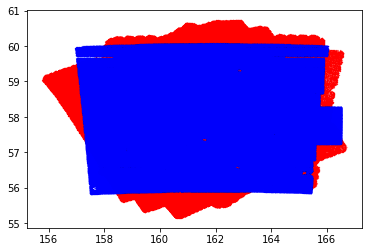

In [5]:
x = help_cat['ra']
y = help_cat['dec']
plt.scatter(x,y,s=0.01,c='red')

x = master['ALPHA_J2000']
y = master['DELTA_J2000']
plt.scatter(x,y,s=0.01,c='blue')
plt.show()

In [6]:
colnames = master.colnames
aper = '_2'
low_SNR = 0
mask = []
for n,name in enumerate(colnames):
    if 'FLUX_' not in name:
        continue
    if aper not in name:
        continue
    name_err = name.replace('FLUX','FLUXERR')
    snr = master[name]/master[name_err]
    if len(mask)==0:
        mask = snr<3.0
    else:
        mask = mask & (snr<3.0)
print(np.sum(mask))

75261


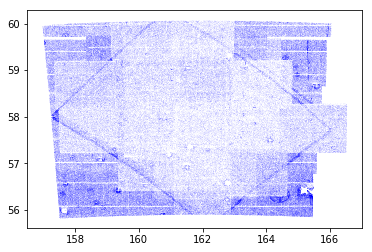

In [7]:
x = master['ALPHA_J2000'][mask]
y = master['DELTA_J2000'][mask]
plt.scatter(x,y,s=0.0001,c='blue')
plt.show()

In [60]:
idx1,idx2,sep,_ = search_around_sky(lofar_skycoord,help_skycoord,1*u.arcsec)

2418088


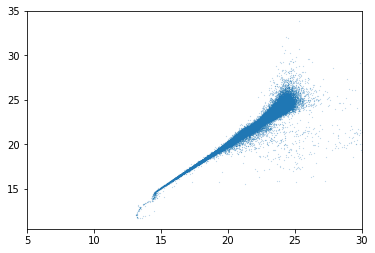

In [61]:
uniq,count = np.unique(idx1,return_counts=True)
mask = count > 1
ids = uniq[mask]
mask = ~np.in1d(idx1,ids)
print(np.sum(mask))
x = master['MAG_APER_se2_3'][idx1][mask]
y = help_cat['m_ap_irac_i2'][idx2][mask]
plt.scatter(x,y,s=0.01)
plt.xlim(5,30)
plt.show()

In [107]:
idx1,d2d,d3d = lofar_skycoord.match_to_catalog_sky(help_skycoord)
d2d = d2d.value*3600

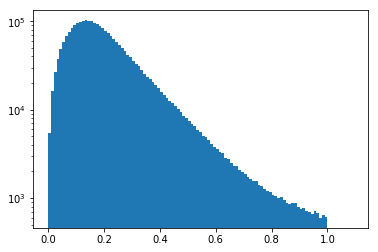

In [108]:
mask = d2d < 1
y = d2d[mask]
bins = np.arange(0,1.1,0.01)
plt.hist(y,log=True,bins=bins)
plt.show()

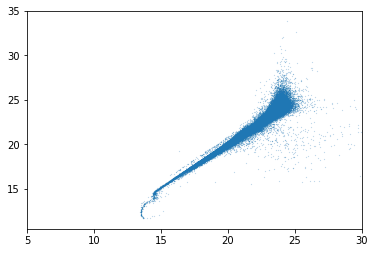

In [110]:
mask = d2d < 1
x = master['MAG_APER_se2_2'][mask]
y = help_cat['m_ap_irac_i2'][idx1][mask]
plt.scatter(x,y,s=0.01)
plt.xlim(5,30)
plt.show()

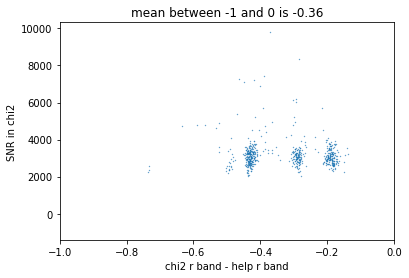

In [132]:
mask = (d2d < 1.0) & (master['MAG_APER_r_2']<17) & inMoc(master['ALPHA_J2000'],master['DELTA_J2000'],moc_se2)
x = master['MAG_APER_r_2'][mask] - help_cat['m_ap_megacam_r'][idx1][mask]
y = master['FLUX_APER_r_3'][mask]/master['FLUXERR_APER_r_3'][mask]
plt.scatter(x,y,s=0.1)
plt.xlim(-1,0)
#plt.ylim(-1,5)
plt.xlabel('chi2 r band - help r band')
plt.ylabel('SNR in chi2')
plt.title('mean between -1 and 0 is -0.36')
plt.show()

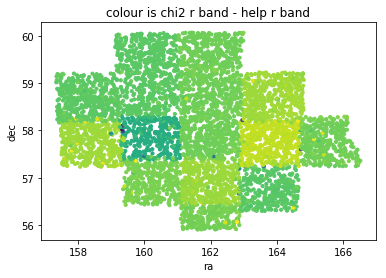

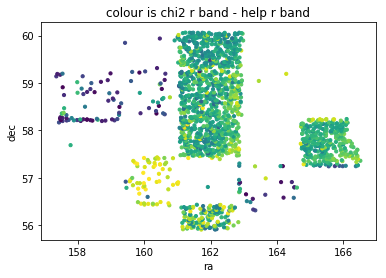

In [224]:
mask = (d2d < 1.0) & (master['MAG_APER_r_2']<18) #& inMoc(master['ALPHA_J2000'],master['DELTA_J2000'],moc_se2)

x = master['ALPHA_J2000'][mask] 
y = master['DELTA_J2000'][mask]
z = master['MAG_APER_r_2'][mask] - help_cat['m_ap_megacam_r'][idx1][mask]
mask = (z>-2) & (z<0)
x = x[mask]
y = y[mask]
z = z[mask]

plt.scatter(x,y,c=z,s=10)
#plt.xlim(-1,0)
#plt.ylim(-1,5)
plt.xlabel('ra')
plt.ylabel('dec')
plt.title('colour is chi2 r band - help r band')
plt.show()
mask = (d2d < 1.0) & (master['MAG_APER_r_2']<18) #& inMoc(master['ALPHA_J2000'],master['DELTA_J2000'],moc_se2)

x = master['ALPHA_J2000'][mask] 
y = master['DELTA_J2000'][mask]
z = master['MAG_APER_r_2'][mask] - help_cat['m_ap_megacam_r'][idx1][mask]
mask = (z>-0.47) & (z<-0.40)
x = x[mask]
y = y[mask]
z = z[mask]

plt.scatter(x,y,c=z,s=10)
#plt.xlim(-1,0)
#plt.ylim(-1,5)
plt.xlabel('ra')
plt.ylabel('dec')
plt.title('colour is chi2 r band - help r band')
plt.show()

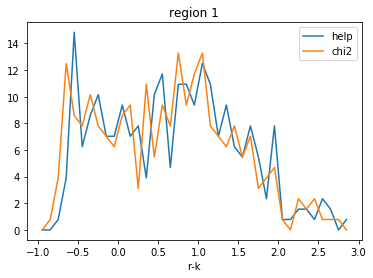

for -0.2< mag dif <0 in help the mean r-k is:0.6779870986938477 +/- 0.8178993463516235
for -0.2< mag dif <0 in chi2 the mean r-k is:0.598451554775238 +/- 0.8251729607582092


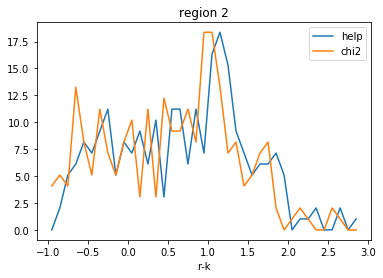

for -0.32< mag dif <-0.22 in help the mean r-k is:0.6756948232650757 +/- 0.805255115032196
for -0.32< mag dif <-0.22 in chi2 the mean r-k is:0.5455838441848755 +/- 0.8063787221908569


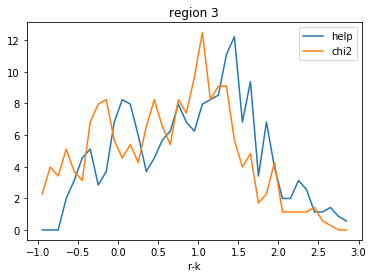

for -0.47< mag dif <-0.4 in help the mean r-k is:0.9336275458335876 +/- 0.8099031448364258
for -0.47< mag dif <-0.4 in chi2 the mean r-k is:0.6297659873962402 +/- 0.8138937950134277


In [320]:
mask = (d2d < 1.0) & (master['MAG_APER_r_2']<18)& (master['MAG_APER_r_2']>0) & (master['MAG_APER_K_2']>0)& (master['MAG_APER_K_2']<18)
ra = master['ALPHA_J2000'][mask] 
dec = master['DELTA_J2000'][mask]
mag_dif = master['MAG_APER_r_2'][mask] - help_cat['m_ap_megacam_r'][idx1][mask]
r_k_help = help_cat['m_ap_megacam_r'][idx1][mask] - help_cat['m_ap_ukidss_k'][idx1][mask]
r_k_chi2 = master['MAG_APER_r_2'][mask] - master['MAG_APER_K_2'][mask]

bins = np.arange(-1,3,0.1)
x = get_center(bins)

mask = (ra>162.9)&(ra<164.5) & (dec>57.3)&(dec<58.1) & (~np.isnan(r_k_help))#& (mag_dif>-0.2) & (mag_dif<0)
y = np.histogram(r_k_help[mask],bins=bins)[0]/(1.6*0.8)
plt.plot(x,y,label='help')
y = np.histogram(r_k_chi2[mask],bins=bins)[0]/(1.6*0.8)
plt.plot(x,y,label='chi2')
plt.xlabel('r-k')
plt.title('region 1')
plt.legend()
plt.show()
print('for -0.2< mag dif <0 in help the mean r-k is:{} +/- {}'.format(np.nanmean(r_k_help[mask]),np.nanstd(r_k_help[mask])))
print('for -0.2< mag dif <0 in chi2 the mean r-k is:{} +/- {}'.format(np.nanmean(r_k_chi2[mask]),np.nanstd(r_k_chi2[mask])))

mask = (ra>161.2)&(ra<162.6) & (dec>56.6)&(dec<57.3) & (~np.isnan(r_k_help)) #& (mag_dif>-0.32) & (mag_dif<-0.22)
y = np.histogram(r_k_help[mask],bins=bins)[0]/(1.4*0.7)
plt.plot(x,y,label='help')
y = np.histogram(r_k_chi2[mask],bins=bins)[0]/(1.4*0.7)
plt.plot(x,y,label='chi2')
plt.xlabel('r-k')
plt.title('region 2')
plt.legend()
plt.show()
print('for -0.32< mag dif <-0.22 in help the mean r-k is:{} +/- {}'.format(np.nanmean(r_k_help[mask]),np.nanstd(r_k_help[mask])))
print('for -0.32< mag dif <-0.22 in chi2 the mean r-k is:{} +/- {}'.format(np.nanmean(r_k_chi2[mask]),np.nanstd(r_k_chi2[mask])))

mask = (ra>161.2)&(ra<162.8) & (dec>57.6)&(dec<59.8) & (~np.isnan(r_k_help)) #& (mag_dif>-0.47) & (mag_dif<-0.4)
y = np.histogram(r_k_help[mask],bins=bins)[0]/(1.6*2.2)
plt.plot(x,y,label='help')
y = np.histogram(r_k_chi2[mask],bins=bins)[0]/(1.6*2.2)
plt.plot(x,y,label='chi2')
plt.xlabel('r-k')
plt.title('region 3')
plt.legend()
plt.show()
print('for -0.47< mag dif <-0.4 in help the mean r-k is:{} +/- {}'.format(np.nanmean(r_k_help[mask]),np.nanstd(r_k_help[mask])))
print('for -0.47< mag dif <-0.4 in chi2 the mean r-k is:{} +/- {}'.format(np.nanmean(r_k_chi2[mask]),np.nanstd(r_k_chi2[mask])))



In [307]:
mask = (d2d < 1.0) & (master['MAG_APER_r_2']<18)& (master['MAG_APER_r_2']>0) & (master['MAG_APER_K_2']>0)& (master['MAG_APER_K_2']<18)
ra = master['ALPHA_J2000'][mask] 
dec = master['DELTA_J2000'][mask]
mag_dif = master['MAG_APER_r_2'][mask] - help_cat['m_ap_megacam_r'][idx1][mask]
r_k_help = help_cat['m_ap_megacam_r'][idx1][mask] - help_cat['m_ap_ukidss_k'][idx1][mask]
r_k_chi2 = master['MAG_APER_r_2'][mask] - master['MAG_APER_K_2'][mask]



mask = (ra>162.9)&(ra<164.5) & (dec>57.3)&(dec<58.1) #& (mag_dif>-0.2) & (mag_dif<0)
print('for -0.2< mag dif <0 in help the median r-k is:{} +/- {}'.format(np.nanmedian(r_k_help[mask]),np.nanstd(r_k_help[mask])))
print('for -0.2< mag dif <0 in chi2 the median r-k is:{} +/- {}'.format(np.nanmedian(r_k_chi2[mask]),np.nanstd(r_k_chi2[mask])))

mask = (ra>161.2)&(ra<162.6) & (dec>56.6)&(dec<57.3) #& (mag_dif>-0.32) & (mag_dif<-0.22)
print('for -0.32< mag dif <-0.22 in help the median r-k is:{} +/- {}'.format(np.nanmedian(r_k_help[mask]),np.nanstd(r_k_help[mask])))
print('for -0.32< mag dif <-0.22 in chi2 the median r-k is:{} +/- {}'.format(np.nanmedian(r_k_chi2[mask]),np.nanstd(r_k_chi2[mask])))

mask = (ra>161.2)&(ra<162.8) & (dec>57.6)&(dec<59.8) #& (mag_dif>-0.47) & (mag_dif<-0.4)
print('for -0.47< mag dif <-0.4 in help the median r-k is:{} +/- {}'.format(np.nanmedian(r_k_help[mask]),np.nanstd(r_k_help[mask])))
print('for -0.47< mag dif <-0.4 in chi2 the median r-k is:{} +/- {}'.format(np.nanmedian(r_k_chi2[mask]),np.nanstd(r_k_chi2[mask])))




for -0.2< mag dif <0 in help the median r-k is:0.7155675888061523 +/- 0.8178993463516235
for -0.2< mag dif <0 in chi2 the median r-k is:0.6740894317626953 +/- 0.8271946907043457
for -0.32< mag dif <-0.22 in help the median r-k is:0.7374134063720703 +/- 0.805255115032196
for -0.32< mag dif <-0.22 in chi2 the median r-k is:0.6713695526123047 +/- 0.8096510171890259
for -0.47< mag dif <-0.4 in help the median r-k is:1.025090217590332 +/- 0.8099031448364258
for -0.47< mag dif <-0.4 in chi2 the median r-k is:0.7219371795654297 +/- 0.8227435350418091


/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


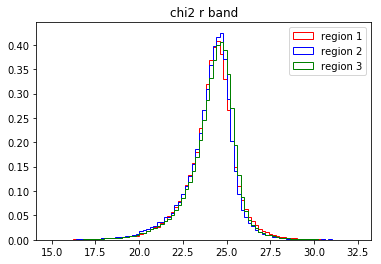

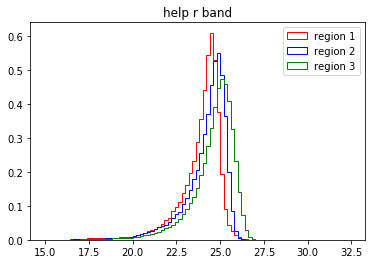

In [281]:
bins = np.arange(15,32.5,0.2)
masksep = (d2d < 1.0)
ra = master['ALPHA_J2000'][masksep] 
dec = master['DELTA_J2000'][masksep]


mask = (master['FLUX_APER_r_3'][masksep] != -99) & (ra>162.9)&(ra<164.5) & (dec>57.3)&(dec<58.1)
y = master['MAG_APER_r_3'][masksep][mask]#/(1.6*0.8)
plt.hist(y,bins=bins,color='red',label='region 1',density=True,histtype='step')

mask = (master['FLUX_APER_r_3'][masksep] != -99) & (ra>161.2)&(ra<162.6) & (dec>56.6)&(dec<57.3)
y = master['MAG_APER_r_3'][masksep][mask]#/(1.4*0.7)
plt.hist(y,bins=bins,color='blue',label='region 2',density=True,histtype='step')

mask = (master['FLUX_APER_r_3'][masksep] != -99) & (ra>161.2)&(ra<162.8) & (dec>57.6)&(dec<59.8)
y = master['MAG_APER_r_3'][masksep][mask]#/(1.4*0.7)
plt.hist(y,bins=bins,color='green',label='region 3',density=True,histtype='step')


#plt.xlim(15,20)
#plt.ylim(0.0,0.01)
plt.title('chi2 r band')
plt.legend()
plt.show()

ra = help_cat['ra']
dec = help_cat['dec']
mask = (~np.isnan(help_cat['m_ap_megacam_r'])) & (ra>162.9)&(ra<164.5) & (dec>57.3)&(dec<58.1)
y = help_cat['m_ap_megacam_r'][mask]
plt.hist(y,bins=bins,color='red',label='region 1',density=True,histtype='step')

mask = (~np.isnan(help_cat['m_ap_megacam_r'])) & (ra>161.2)&(ra<162.6) & (dec>56.6)&(dec<57.3)
y = help_cat['m_ap_megacam_r'][mask]
plt.hist(y,bins=bins,color='blue',label='region 2',density=True,histtype='step')

mask = (~np.isnan(help_cat['m_ap_megacam_r'])) & (ra>161.2)&(ra<162.8) & (dec>57.6)&(dec<59.8)
y = help_cat['m_ap_megacam_r'][mask]
plt.hist(y,bins=bins,color='green',label='region 3',density=True,histtype='step')


#plt.xlim(15,20)
#plt.ylim(0.0,0.01)
plt.title('help r band')
plt.legend()
plt.show()

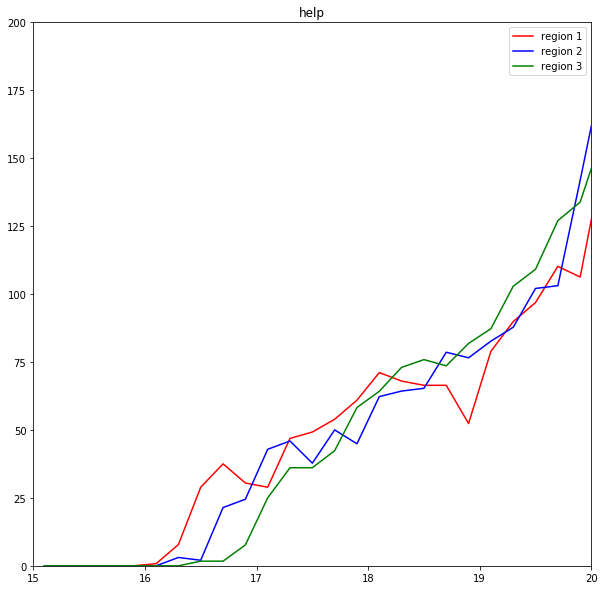

In [302]:
#Same as above but with a correction to the magnitudes for the help catalogue 
#to see if it makes the distribution agree

bins = np.arange(15,32.5,0.2)
fig = plt.figure(figsize=[10,10])

ra = help_cat['ra']
dec = help_cat['dec']
mask = (~np.isnan(help_cat['m_ap_megacam_r'])) & (ra>162.9)&(ra<164.5) & (dec>57.3)&(dec<58.1)
x = get_center(bins)
y = np.histogram(help_cat['m_ap_megacam_r'][mask],bins=bins)[0]/(1.6*0.8)
plt.plot(x,y,color='red',label='region 1')

mask = (~np.isnan(help_cat['m_ap_megacam_r'])) & (ra>161.2)&(ra<162.6) & (dec>56.6)&(dec<57.3)
x = get_center(bins)#-0.3
y = np.histogram(help_cat['m_ap_megacam_r'][mask],bins=bins)[0]/(1.4*0.7)
plt.plot(x,y,color='blue',label='region 2')

mask = (~np.isnan(help_cat['m_ap_megacam_r'])) & (ra>161.2)&(ra<162.8) & (dec>57.6)&(dec<59.8)
x = get_center(bins)#-0.6
y = np.histogram(help_cat['m_ap_megacam_r'][mask],bins=bins)[0]/(1.6*2.2)
plt.plot(x,y,color='green',label='region 3')


plt.xlim(15,20)
plt.ylim(0.0,200)
plt.title('help')
plt.legend()
plt.show()

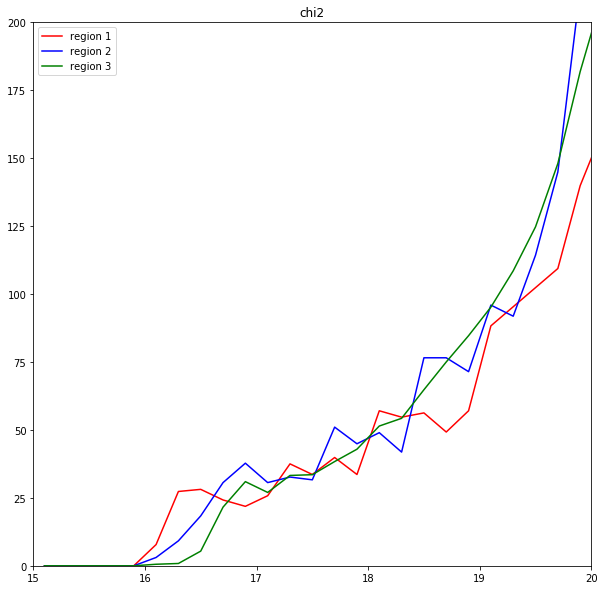

In [298]:
#Same as above but with a correction to the magnitudes for the help catalogue 
#to see if it makes the distribution agree

bins = np.arange(15,32.5,0.2)
fig = plt.figure(figsize=[10,10])

ra = master['ALPHA_J2000']
dec = master['DELTA_J2000']
mask = (~np.isnan(master['MAG_APER_r_2'])) & (ra>162.9)&(ra<164.5) & (dec>57.3)&(dec<58.1)
x = get_center(bins)
y = np.histogram(master['MAG_APER_r_2'][mask],bins=bins)[0]/(1.6*0.8)
plt.plot(x,y,color='red',label='region 1')

mask = (~np.isnan(master['MAG_APER_r_2'])) & (ra>161.2)&(ra<162.6) & (dec>56.6)&(dec<57.3)
x = get_center(bins)#-0.3
y = np.histogram(master['MAG_APER_r_2'][mask],bins=bins)[0]/(1.4*0.7)
plt.plot(x,y,color='blue',label='region 2')

mask = (~np.isnan(master['MAG_APER_r_2'])) & (ra>161.2)&(ra<162.8) & (dec>57.6)&(dec<59.8)
x = get_center(bins)#-0.6
y = np.histogram(master['MAG_APER_r_2'][mask],bins=bins)[0]/(1.6*2.2)
plt.plot(x,y,color='green',label='region 3')


plt.xlim(15,20)
plt.ylim(0.0,200)

plt.title('chi2')
plt.legend()
plt.show()

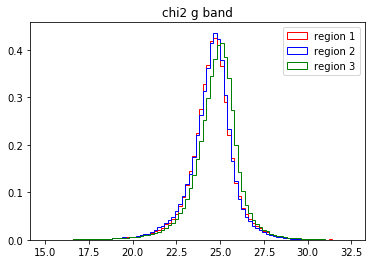

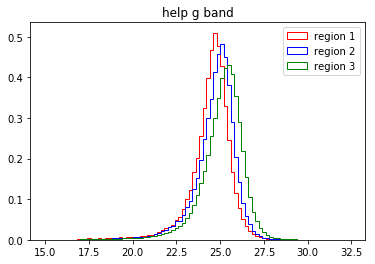

In [280]:
bins = np.arange(15,32.5,0.2)
masksep = (d2d < 1.0)
ra = master['ALPHA_J2000'][masksep] 
dec = master['DELTA_J2000'][masksep]


mask = (master['FLUX_APER_g_3'][masksep] != -99) & (ra>162.9)&(ra<164.5) & (dec>57.3)&(dec<58.1)
y = master['MAG_APER_g_3'][masksep][mask]#/(1.6*0.8)
plt.hist(y,bins=bins,color='red',label='region 1',density=True,histtype='step')

mask = (master['FLUX_APER_g_3'][masksep] != -99) & (ra>161.2)&(ra<162.6) & (dec>56.6)&(dec<57.3)
y = master['MAG_APER_g_3'][masksep][mask]#/(1.4*0.7)
plt.hist(y,bins=bins,color='blue',label='region 2',density=True,histtype='step')

mask = (master['FLUX_APER_g_3'][masksep] != -99) & (ra>161.2)&(ra<162.8) & (dec>57.6)&(dec<59.8)
y = master['MAG_APER_g_3'][masksep][mask]#/(1.4*0.7)
plt.hist(y,bins=bins,color='green',label='region 3',density=True,histtype='step')


#plt.xlim(15,20)
#plt.ylim(0.0,0.01)
plt.title('chi2 g band')
plt.legend()
plt.show()

ra = help_cat['ra']
dec = help_cat['dec']
mask = (~np.isnan(help_cat['m_ap_megacam_g'])) & (ra>162.9)&(ra<164.5) & (dec>57.3)&(dec<58.1)
y = help_cat['m_ap_megacam_g'][mask]
plt.hist(y,bins=bins,color='red',label='region 1',density=True,histtype='step')

mask = (~np.isnan(help_cat['m_ap_megacam_g'])) & (ra>161.2)&(ra<162.6) & (dec>56.6)&(dec<57.3)
y = help_cat['m_ap_megacam_g'][mask]
plt.hist(y,bins=bins,color='blue',label='region 2',density=True,histtype='step')

mask = (~np.isnan(help_cat['m_ap_megacam_g'])) & (ra>161.2)&(ra<162.8) & (dec>57.6)&(dec<59.8)
y = help_cat['m_ap_megacam_g'][mask]
plt.hist(y,bins=bins,color='green',label='region 3',density=True,histtype='step')


#plt.xlim(15,20)
#plt.ylim(0.0,0.01)
plt.title('help g band')
plt.legend()
plt.show()

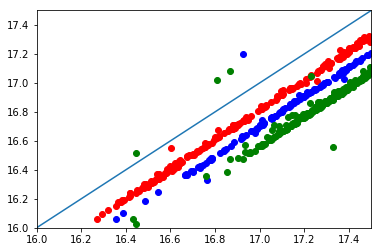

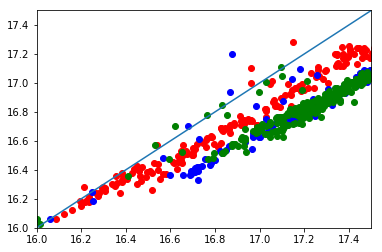

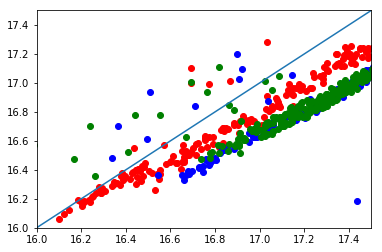

In [295]:
mask_help = help_cat['m_ap_megacam_r']<17.5
mask_chi2 = (master['MAG_APER_r_2']<17.5) & (master['MAG_APER_r_2']>0)
idx1_bright,idx2_bright,sep_bright,_ = search_around_sky(lofar_skycoord[mask_chi2],help_skycoord[mask_help],1*u.arcsec)

help_r_bright = help_cat[mask_help][idx2_bright]
chi2_r_bright = master[mask_chi2][idx1_bright]
ra = chi2_r_bright['ALPHA_J2000']
dec = chi2_r_bright['DELTA_J2000']

mask = (ra>162.9)&(ra<164.5) & (dec>57.3)&(dec<58.1)
x = help_r_bright['m_ap_megacam_r'][mask]
y = chi2_r_bright['MAG_APER_r_2'][mask]#/(1.6*0.8)
plt.scatter(x,y,color='red',label='region 1')


mask =  (ra>161.2)&(ra<162.6) & (dec>56.6)&(dec<57.3)
x = help_r_bright['m_ap_megacam_r'][mask]
y = chi2_r_bright['MAG_APER_r_2'][mask]#/(1.6*0.8)
plt.scatter(x,y,color='blue',label='region 2')

mask =  (ra>161.2)&(ra<162.8) & (dec>57.6)&(dec<59.8)
x = help_r_bright['m_ap_megacam_r'][mask]
y = chi2_r_bright['MAG_APER_r_2'][mask]#/(1.6*0.8)
plt.scatter(x,y,color='green',label='region 3')

plt.plot([16,17.5],[16,17.5])
plt.xlim(16,17.5)
plt.ylim(16,17.5)
plt.show()



mask = (ra>162.9)&(ra<164.5) & (dec>57.3)&(dec<58.1)
x = help_r_bright['m_ap_wfc_r'][mask]
y = chi2_r_bright['MAG_APER_r_2'][mask]#/(1.6*0.8)
plt.scatter(x,y,color='red',label='region 1')


mask =  (ra>161.2)&(ra<162.6) & (dec>56.6)&(dec<57.3)
x = help_r_bright['m_ap_wfc_r'][mask]
y = chi2_r_bright['MAG_APER_r_2'][mask]#/(1.6*0.8)
plt.scatter(x,y,color='blue',label='region 2')

mask =  (ra>161.2)&(ra<162.8) & (dec>57.6)&(dec<59.8)
x = help_r_bright['m_ap_wfc_r'][mask]
y = chi2_r_bright['MAG_APER_r_2'][mask]#/(1.6*0.8)
plt.scatter(x,y,color='green',label='region 3')

plt.plot([16,17.5],[16,17.5])
plt.xlim(16,17.5)
plt.ylim(16,17.5)
plt.show()


mask = (ra>162.9)&(ra<164.5) & (dec>57.3)&(dec<58.1)
x = help_r_bright['m_ap_gpc1_r'][mask]
y = chi2_r_bright['MAG_APER_r_2'][mask]#/(1.6*0.8)
plt.scatter(x,y,color='red',label='region 1')


mask =  (ra>161.2)&(ra<162.6) & (dec>56.6)&(dec<57.3)
x = help_r_bright['m_ap_gpc1_r'][mask]
y = chi2_r_bright['MAG_APER_r_2'][mask]#/(1.6*0.8)
plt.scatter(x,y,color='blue',label='region 2')

mask =  (ra>161.2)&(ra<162.8) & (dec>57.6)&(dec<59.8)
x = help_r_bright['m_ap_gpc1_r'][mask]
y = chi2_r_bright['MAG_APER_r_2'][mask]#/(1.6*0.8)
plt.scatter(x,y,color='green',label='region 3')

plt.plot([16,17.5],[16,17.5])
plt.xlim(16,17.5)
plt.ylim(16,17.5)
plt.show()

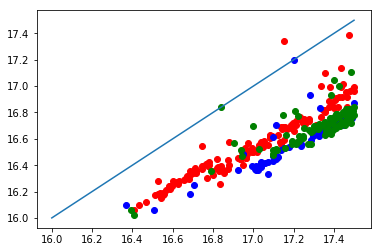

In [366]:
mask_sdss = (sdss['fiberMag_r']<17.5) & (sdss['fiberMag_r']>0)
mask_chi2 = (master['MAG_APER_r_2']<17.5) & (master['MAG_APER_r_2']>0)
idx1_bright,idx2_bright,sep_bright,_ = search_around_sky(lofar_skycoord[mask_chi2],sdss_skycoord[mask_sdss],1*u.arcsec)

sep_bright = sep_bright.value*3600
mask_sep = sep_bright<1
help_r_bright = sdss[mask_sdss][idx2_bright]
help_r_bright = help_r_bright[mask_sep]
chi2_r_bright = master[mask_chi2][idx1_bright]
chi2_r_bright = chi2_r_bright[mask_sep]
ra = chi2_r_bright['ALPHA_J2000']
dec = chi2_r_bright['DELTA_J2000']

mask = (ra>162.9)&(ra<164.5) & (dec>57.3)&(dec<58.1)
x = help_r_bright['fiberMag_r'][mask]
y = chi2_r_bright['MAG_APER_r_2'][mask]#/(1.6*0.8)
plt.scatter(x,y,color='red',label='region 1')


mask =  (ra>161.2)&(ra<162.6) & (dec>56.6)&(dec<57.3)
x = help_r_bright['fiberMag_r'][mask]
y = chi2_r_bright['MAG_APER_r_2'][mask]#/(1.6*0.8)
plt.scatter(x,y,color='blue',label='region 2')

mask =  (ra>161.2)&(ra<162.8) & (dec>57.6)&(dec<59.8)
x = help_r_bright['fiberMag_r'][mask]
y = chi2_r_bright['MAG_APER_r_2'][mask]#/(1.6*0.8)
plt.scatter(x,y,color='green',label='region 3')

plt.plot([16,17.5],[16,17.5])
#plt.xlim(16,19)
#plt.ylim(16,19)
plt.show()

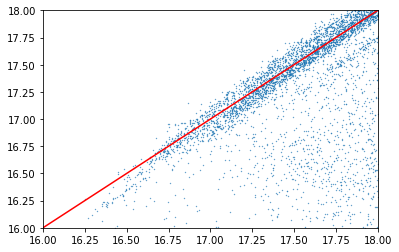

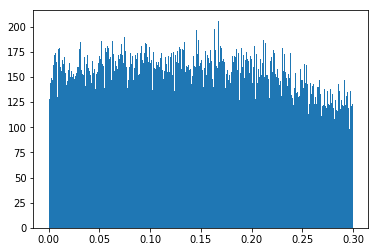

In [379]:
x = help_cat['m_ap_megacam_r']
y = help_cat['m_ap_wfc_r']
plt.scatter(x,y,s=0.1)
plt.plot([16,18],[16,18],c='red')
plt.xlim(16,18)
plt.ylim(16,18)
plt.show()

bins = np.arange(-0.0,0.3,0.0002)
dat = x-y
mask = ~np.isnan(dat)
plt.hist(dat[mask],bins=bins)
plt.show()

In [370]:
tempmask = (ra>162.9)&(ra<164.5) & (dec>57.3)&(dec<58.1)
temp = chi2_r_bright[tempmask]
mask = (temp['petroMag_r'] == np.max(temp['petroMag_r'])) 
temp[mask]
for name in temp.colnames:
    if '_r' in name:
        print('{} = {}'.format(name,temp[mask][name].quantity[0]))

psfMag_r = 17.176088333129883
psfMagErr_r = 0.021378036588430405
fiberMag_r = 17.499797821044922
fiberMagErr_r = 0.0029958426021039486
fiber2Mag_r = 17.984962463378906
fiber2MagErr_r = 0.003454254474490881
petroMag_r = 17.229679107666016
petroMagErr_r = 0.003654808271676302
petroRad_r = 1.0930513143539429
petroR50_r = 0.558625340461731
petroR90_r = 1.225100040435791
deVRad_r = 2.17243632505415e-05
deVAB_r = 0.9069599509239197
deVPhi_r = 25.162137985229492
deVMag_r = 17.181997299194336
deVMagErr_r = 0.005288730375468731
expRad_r = 9.263846732210368e-05
expAB_r = 0.8438038229942322
expPhi_r = 25.11232566833496
expMag_r = 17.182031631469727
expMagErr_r = 0.00528873223811388
modelMag_r = 17.181997299194336
modelMagErr_r = 0.005288729444146156
cmodelMag_r = 17.181997299194336
cmodelMagErr_r = 0.005288730375468731
dered_r = 17.166717529296875
lnLStar_r = -0.5511473417282104
lnLExp_r = -1.5304583311080933
lnLDeV_r = -1.525536060333252
fracDeV_r = 1.0
flags_r = 4503599895973888
type_r = 6
prob

In [371]:
tempmask = (ra>162.9)&(ra<164.5) & (dec>57.3)&(dec<58.1)
temp = help_r_bright[tempmask]
temp[mask]

help_id,field,ra,dec,hp_idx,f_ap_wfc_u,ferr_ap_wfc_u,m_ap_wfc_u,merr_ap_wfc_u,f_wfc_u,ferr_wfc_u,m_wfc_u,merr_wfc_u,f_ap_wfc_g,ferr_ap_wfc_g,m_ap_wfc_g,merr_ap_wfc_g,f_wfc_g,ferr_wfc_g,m_wfc_g,merr_wfc_g,f_ap_wfc_r,ferr_ap_wfc_r,m_ap_wfc_r,merr_ap_wfc_r,f_wfc_r,ferr_wfc_r,m_wfc_r,merr_wfc_r,f_ap_wfc_i,ferr_ap_wfc_i,m_ap_wfc_i,merr_ap_wfc_i,f_wfc_i,ferr_wfc_i,m_wfc_i,merr_wfc_i,f_ap_wfc_z,ferr_ap_wfc_z,m_ap_wfc_z,merr_ap_wfc_z,f_wfc_z,ferr_wfc_z,m_wfc_z,merr_wfc_z,f_ap_gpc1_g,ferr_ap_gpc1_g,m_ap_gpc1_g,merr_ap_gpc1_g,f_gpc1_g,ferr_gpc1_g,m_gpc1_g,merr_gpc1_g,f_ap_gpc1_r,ferr_ap_gpc1_r,m_ap_gpc1_r,merr_ap_gpc1_r,f_gpc1_r,ferr_gpc1_r,m_gpc1_r,merr_gpc1_r,f_ap_gpc1_i,ferr_ap_gpc1_i,m_ap_gpc1_i,merr_ap_gpc1_i,f_gpc1_i,ferr_gpc1_i,m_gpc1_i,merr_gpc1_i,f_ap_gpc1_z,ferr_ap_gpc1_z,m_ap_gpc1_z,merr_ap_gpc1_z,f_gpc1_z,ferr_gpc1_z,m_gpc1_z,merr_gpc1_z,f_ap_gpc1_y,ferr_ap_gpc1_y,m_ap_gpc1_y,merr_ap_gpc1_y,f_gpc1_y,ferr_gpc1_y,m_gpc1_y,merr_gpc1_y,f_ap_megacam_u,ferr_ap_megacam_u,m_ap_megacam_u,merr_ap_megacam_u,f_megacam_u,ferr_megacam_u,m_megacam_u,merr_megacam_u,f_ap_megacam_g,ferr_ap_megacam_g,m_ap_megacam_g,merr_ap_megacam_g,f_megacam_g,ferr_megacam_g,m_megacam_g,merr_megacam_g,f_ap_megacam_r,ferr_ap_megacam_r,m_ap_megacam_r,merr_ap_megacam_r,f_megacam_r,ferr_megacam_r,m_megacam_r,merr_megacam_r,f_ap_megacam_z,ferr_ap_megacam_z,m_ap_megacam_z,merr_ap_megacam_z,f_megacam_z,ferr_megacam_z,m_megacam_z,merr_megacam_z,f_ap_ukidss_k,ferr_ap_ukidss_k,m_ap_ukidss_k,merr_ap_ukidss_k,f_ukidss_k,ferr_ukidss_k,m_ukidss_k,merr_ukidss_k,f_ap_irac_i3,ferr_ap_irac_i3,m_ap_irac_i3,merr_ap_irac_i3,f_irac_i3,ferr_irac_i3,m_irac_i3,merr_irac_i3,f_ap_irac_i4,ferr_ap_irac_i4,m_ap_irac_i4,merr_ap_irac_i4,f_irac_i4,ferr_irac_i4,m_irac_i4,merr_irac_i4,f_ap_irac_i1,ferr_ap_irac_i1,m_ap_irac_i1,merr_ap_irac_i1,f_irac_i1,ferr_irac_i1,m_irac_i1,merr_irac_i1,f_ap_irac_i2,ferr_ap_irac_i2,m_ap_irac_i2,merr_ap_irac_i2,f_irac_i2,ferr_irac_i2,m_irac_i2,merr_irac_i2,f_ap_ukidss_j,ferr_ap_ukidss_j,m_ap_ukidss_j,merr_ap_ukidss_j,f_ukidss_j,ferr_ukidss_j,m_ukidss_j,merr_ukidss_j,m_megacam_i,ferr_megacam_i,merr_megacam_i,f_megacam_i,m_megacam_y,ferr_megacam_y,merr_megacam_y,f_megacam_y,stellarity,stellarity_origin,zspec,zspec_qual,zspec_association_flag,ebv,f_mips_24,ferr_mips_24,flag_mips_24,f_pacs_green,ferr_pacs_green,flag_pacs_green,f_pacs_red,ferr_pacs_red,flag_pacs_red,f_spire_250,ferr_spire_250,flag_spire_250,f_spire_350,ferr_spire_350,flag_spire_350,f_spire_500,ferr_spire_500,flag_spire_500,redshift,flag_megacam_i,flag_megacam_y,flag_cleaned,flag_merged,flag_gaia,flag_optnir_obs,flag_optnir_det,flag_gpc1_g,flag_gpc1_r,flag_gpc1_i,flag_gpc1_z,flag_gpc1_y,flag_irac_i1,flag_irac_i2,flag_irac_i3,flag_irac_i4,flag_wfc_u,flag_megacam_u,flag_wfc_g,flag_megacam_g,flag_wfc_r,flag_megacam_r,flag_wfc_i,flag_wfc_z,flag_megacam_z,cigale_mstar,cigale_mstar_err,cigale_sfr,cigale_sfr_err,cigale_dustlumin,cigale_dustlumin_err,cigale_dustlumin_ironly,cigale_dustlumin_ironly_err,flag_cigale,flag_cigale_opt,flag_cigale_ir,flag_cigale_ironly
,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,mag,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,uJy,uJy,,,uJy,uJy,,,uJy,uJy,,,uJy,uJy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,uJy,,,mJy,,,mJy,,,mJy,,,mJy,,,mJy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
bytes33,bytes18,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float

/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


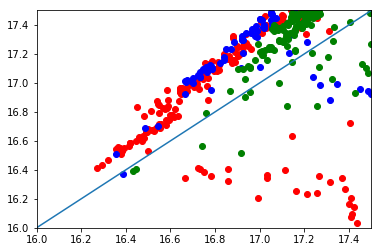

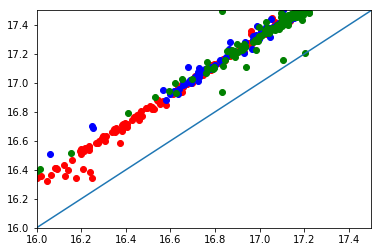

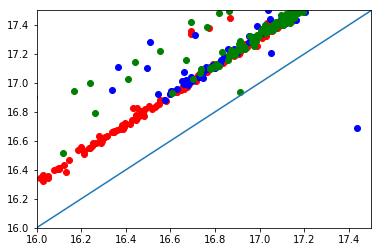

In [367]:
mask_help = help_cat['m_ap_megacam_r']<17.5
mask_sdss = (sdss['fiberMag_r']<17.5) & (sdss['fiberMag_r']>0)
idx1_bright,idx2_bright,sep_bright,_ = search_around_sky(sdss_skycoord[mask_sdss],help_skycoord[mask_help],1*u.arcsec)

help_r_bright = help_cat[mask_help][idx2_bright]
chi2_r_bright = sdss[mask_sdss][idx1_bright]
ra = chi2_r_bright['ra']
dec = chi2_r_bright['dec']

mask = (ra>162.9)&(ra<164.5) & (dec>57.3)&(dec<58.1)
x = help_r_bright['m_ap_megacam_r'][mask]
y = chi2_r_bright['fiberMag_r'][mask]#/(1.6*0.8)
plt.scatter(x,y,color='red',label='region 1')


mask =  (ra>161.2)&(ra<162.6) & (dec>56.6)&(dec<57.3)
x = help_r_bright['m_ap_megacam_r'][mask]
y = chi2_r_bright['fiberMag_r'][mask]#/(1.6*0.8)
plt.scatter(x,y,color='blue',label='region 2')

mask =  (ra>161.2)&(ra<162.8) & (dec>57.6)&(dec<59.8)
x = help_r_bright['m_ap_megacam_r'][mask]
y = chi2_r_bright['fiberMag_r'][mask]#/(1.6*0.8)
plt.scatter(x,y,color='green',label='region 3')

plt.plot([16,17.5],[16,17.5])
plt.xlim(16,17.5)
plt.ylim(16,17.5)
plt.show()



mask = (ra>162.9)&(ra<164.5) & (dec>57.3)&(dec<58.1)
x = help_r_bright['m_ap_wfc_r'][mask]
y = chi2_r_bright['fiberMag_r'][mask]#/(1.6*0.8)
plt.scatter(x,y,color='red',label='region 1')


mask =  (ra>161.2)&(ra<162.6) & (dec>56.6)&(dec<57.3)
x = help_r_bright['m_ap_wfc_r'][mask]
y = chi2_r_bright['fiberMag_r'][mask]#/(1.6*0.8)
plt.scatter(x,y,color='blue',label='region 2')

mask =  (ra>161.2)&(ra<162.8) & (dec>57.6)&(dec<59.8)
x = help_r_bright['m_ap_wfc_r'][mask]
y = chi2_r_bright['fiberMag_r'][mask]#/(1.6*0.8)
plt.scatter(x,y,color='green',label='region 3')

plt.plot([16,17.5],[16,17.5])
plt.xlim(16,17.5)
plt.ylim(16,17.5)
plt.show()


mask = (ra>162.9)&(ra<164.5) & (dec>57.3)&(dec<58.1)
x = help_r_bright['m_ap_gpc1_r'][mask]
y = chi2_r_bright['fiberMag_r'][mask]#/(1.6*0.8)
plt.scatter(x,y,color='red',label='region 1')


mask =  (ra>161.2)&(ra<162.6) & (dec>56.6)&(dec<57.3)
x = help_r_bright['m_ap_gpc1_r'][mask]
y = chi2_r_bright['fiberMag_r'][mask]#/(1.6*0.8)
plt.scatter(x,y,color='blue',label='region 2')

mask =  (ra>161.2)&(ra<162.8) & (dec>57.6)&(dec<59.8)
x = help_r_bright['m_ap_gpc1_r'][mask]
y = chi2_r_bright['fiberMag_r'][mask]#/(1.6*0.8)
plt.scatter(x,y,color='green',label='region 3')

plt.plot([16,17.5],[16,17.5])
plt.xlim(16,17.5)
plt.ylim(16,17.5)
plt.show()

/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


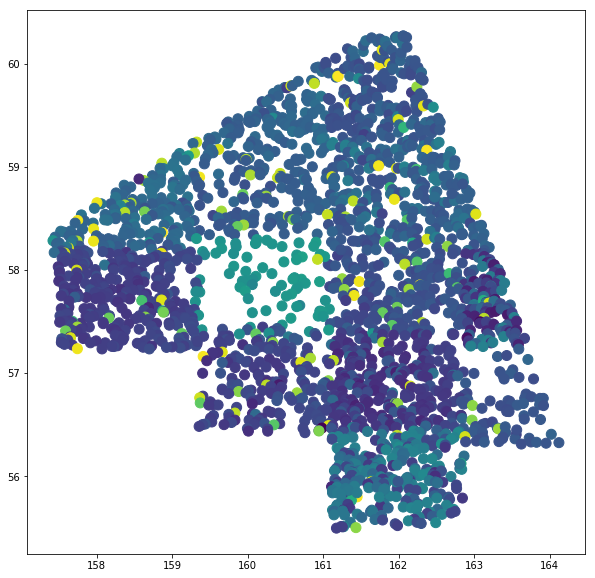

In [415]:
mask_help = help_cat['m_ap_megacam_r']<18
mask_sdss = (sdss_dr12['rmag']<18) & (sdss_dr12['rmag']>15)
idx1_bright,idx2_bright,sep_bright,_ = search_around_sky(sdss_dr12_skycoord[mask_sdss],help_skycoord[mask_help],1*u.arcsec)

help_r_bright = help_cat[mask_help][idx2_bright]
chi2_r_bright = sdss_dr12[mask_sdss][idx1_bright]
ra = help_r_bright['ra']
dec = help_r_bright['dec']


x = help_r_bright['m_ap_megacam_r']
y = chi2_r_bright['rmag']
mdiff = x-y
mask =mdiff<0.75
fig = plt.figure(figsize=[10,10])
plt.scatter(ra[mask],dec[mask],c=mdiff[mask],s=100)
plt.show()



In [ ]:
mask_help = help_cat['m_ap_megacam_r']<18
mask_sdss = (sdss_dr12['rmag']<18) & (sdss_dr12['rmag']>15)
idx1_bright,idx2_bright,sep_bright,_ = search_around_sky(sdss_dr12_skycoord[mask_sdss],help_skycoord[mask_help],1*u.arcsec)

help_r_bright = help_cat[mask_help][idx2_bright]
chi2_r_bright = sdss_dr12[mask_sdss][idx1_bright]
ra = help_r_bright['ra']
dec = help_r_bright['dec']


x = help_r_bright['m_ap_megacam_r']
y = chi2_r_bright['rmag']
mdiff = x-y
mask =mdiff<0.75
fig = plt.figure(figsize=[10,10])
plt.scatter(ra[mask],dec[mask],c=mdiff[mask],s=100)
plt.show()




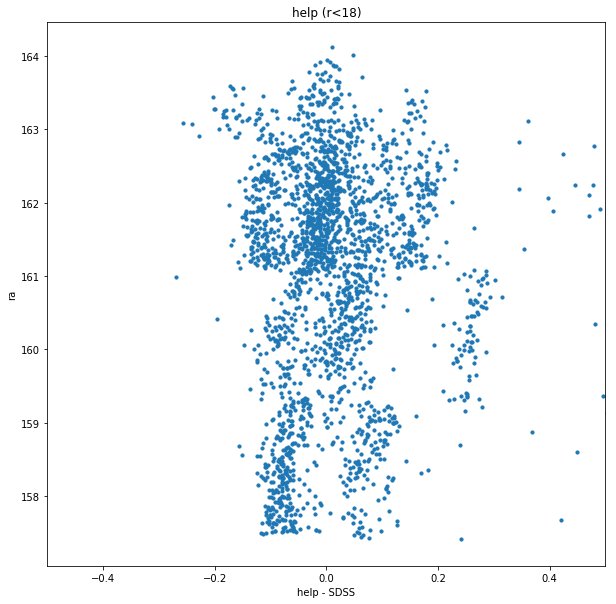

In [427]:
mask_help = help_cat['m_ap_megacam_r']<18
mask_sdss = (sdss_dr12['rmag']<18) & (sdss_dr12['rmag']>15)
idx1_bright,idx2_bright,sep_bright,_ = search_around_sky(sdss_dr12_skycoord[mask_sdss],help_skycoord[mask_help],1*u.arcsec)

help_r_bright = help_cat[mask_help][idx2_bright]
chi2_r_bright = sdss_dr12[mask_sdss][idx1_bright]
ra = help_r_bright['ra']
dec = help_r_bright['dec']


x = help_r_bright['m_ap_megacam_r']
y = chi2_r_bright['rmag']
mdiff = x-y
fig = plt.figure(figsize=[10,10])
plt.scatter(mdiff,ra,s=10)
plt.xlim(-0.5,0.5)
plt.title('help (r<18)')
plt.xlabel('help - SDSS')
plt.ylabel('ra')
plt.show()

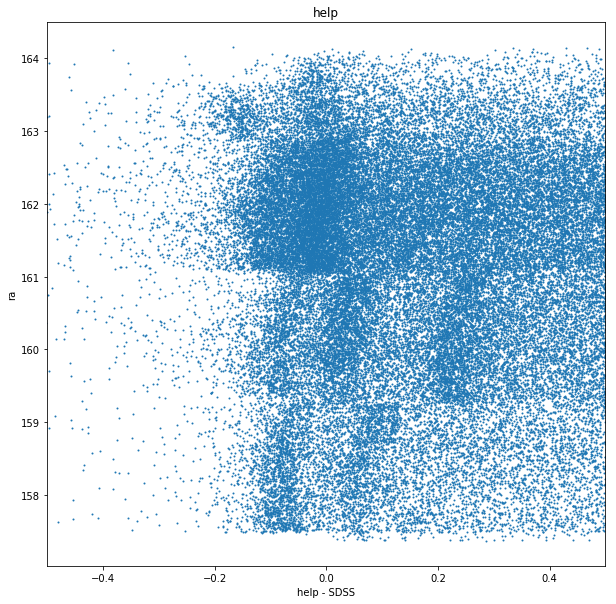

In [432]:
idx1_bright,idx2_bright,sep_bright,_ = search_around_sky(sdss_dr12_skycoord,help_skycoord,1*u.arcsec)

help_r_bright = help_cat[idx2_bright]
chi2_r_bright = sdss_dr12[idx1_bright]
ra = help_r_bright['ra']
dec = help_r_bright['dec']


x = help_r_bright['m_ap_megacam_r']
y = chi2_r_bright['rmag']
mdiff = x-y
fig = plt.figure(figsize=[10,10])
plt.scatter(mdiff,ra,s=1)
plt.xlim(-0.5,0.5)
plt.title('help')
plt.xlabel('help - SDSS')
plt.ylabel('ra')
plt.show()

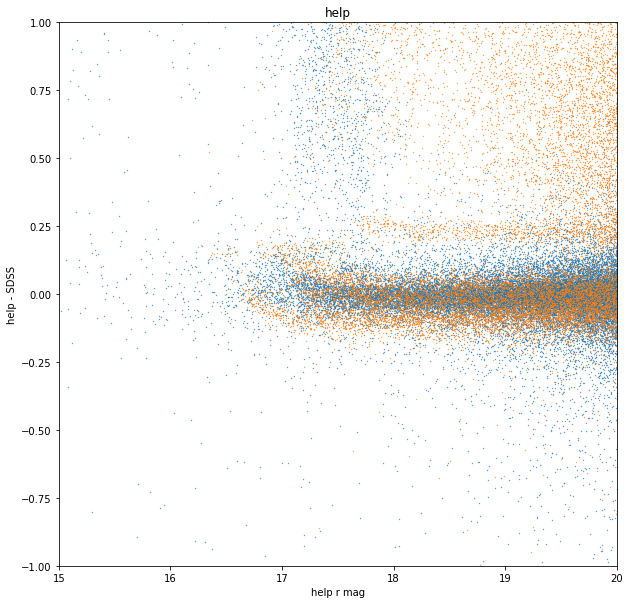

In [441]:
idx1_bright,idx2_bright,sep_bright,_ = search_around_sky(sdss_dr12_skycoord,help_skycoord,1*u.arcsec)

help_r_bright = help_cat[idx2_bright]
chi2_r_bright = sdss_dr12[idx1_bright]
ra = help_r_bright['ra']
dec = help_r_bright['dec']

fig = plt.figure(figsize=[10,10])

x = help_r_bright['m_megacam_r']
y = chi2_r_bright['rmag']
mdiff = x-y

plt.scatter(x,mdiff,s=0.1)

x = help_r_bright['m_ap_megacam_r']
y = chi2_r_bright['rmag']
mdiff = x-y

plt.scatter(x,mdiff,s=0.1)

plt.xlim(15,20)
plt.ylim(-1,1)
plt.title('help')
plt.xlabel('help r mag')
plt.ylabel('help - SDSS')
plt.show()

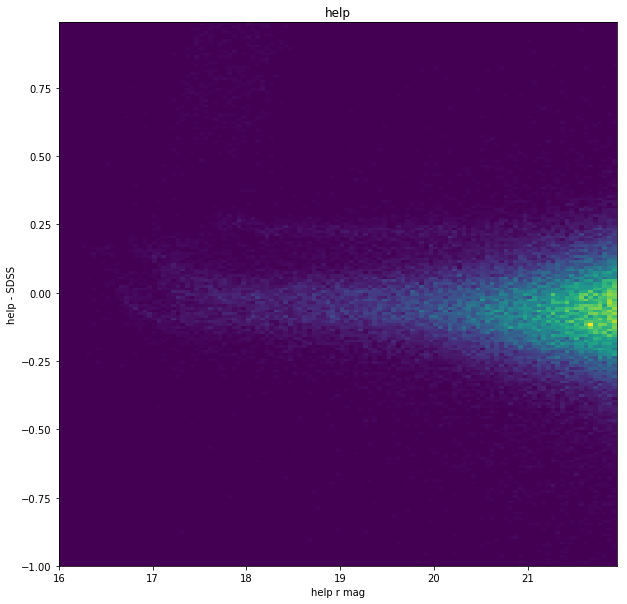

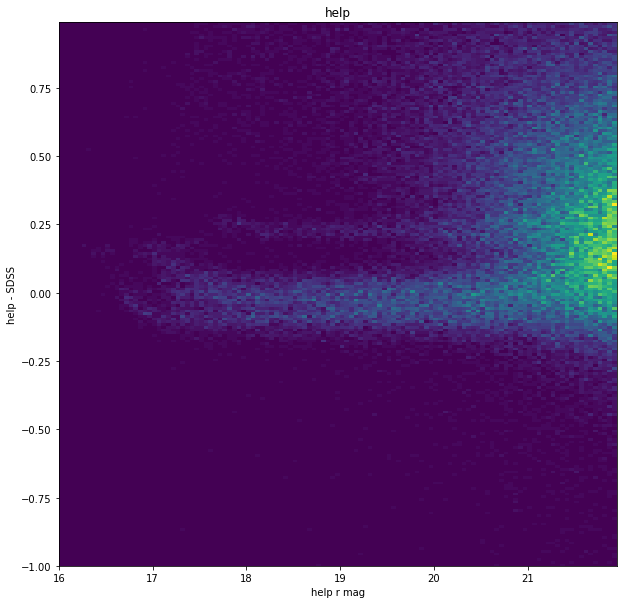

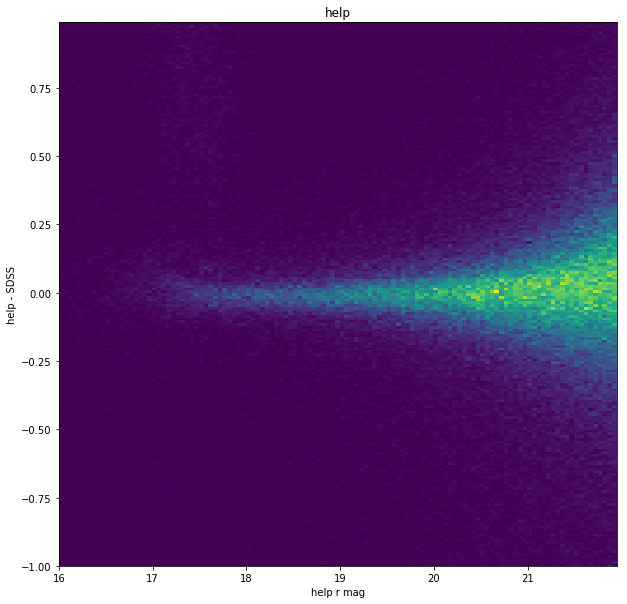

In [476]:
idx1_bright,idx2_bright,sep_bright,_ = search_around_sky(sdss_dr12_skycoord,help_skycoord,1*u.arcsec)

help_r_bright = help_cat[idx2_bright]
chi2_r_bright = sdss_dr12[idx1_bright]
ra = help_r_bright['ra']
dec = help_r_bright['dec']

fig = plt.figure(figsize=[10,10])

mag_bins = np.arange(16,22,0.05)
mdiff_bins = np.arange(-1,1,0.01)
#X,Y = np.meshgrid(mag_bins,mdiff_bins)

x = help_r_bright['m_ap_megacam_r']
y = chi2_r_bright['rpmag']
mdiff = x-y
#Z,_,_ = np.histogram2d(x,mdiff,bins=[mag_bins,mdiff_bins])

plt.hist2d(x,mdiff,bins=[mag_bins,mdiff_bins])


#plt.xlim(15,20)
#plt.ylim(-1,1)
plt.title('help')
plt.xlabel('help r mag')
plt.ylabel('help - SDSS')
plt.show()




fig = plt.figure(figsize=[10,10])
x = help_r_bright['m_ap_megacam_r']
y = chi2_r_bright['rmag']
mdiff = x-y

plt.hist2d(x,mdiff,bins=[mag_bins,mdiff_bins])

plt.title('help')
plt.xlabel('help r mag')
plt.ylabel('help - SDSS')
plt.show()




fig = plt.figure(figsize=[10,10])
x = help_r_bright['m_megacam_r']
y = chi2_r_bright['rmag']
mdiff = x-y

plt.hist2d(x,mdiff,bins=[mag_bins,mdiff_bins])

plt.title('help')
plt.xlabel('help r mag')
plt.ylabel('help - SDSS')
plt.show()

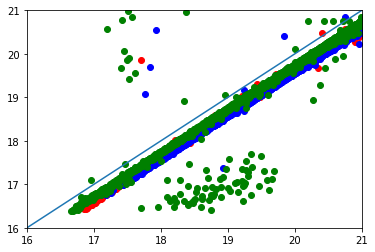

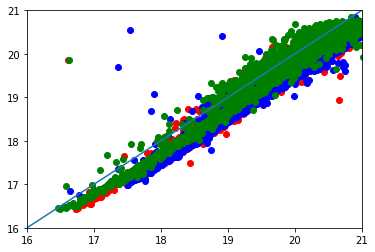

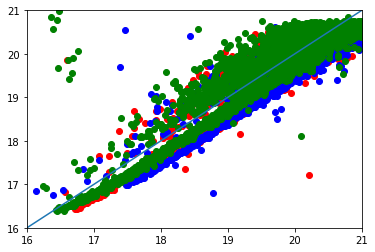

In [434]:
mask_help = help_cat['m_ap_megacam_g']<21
mask_chi2 = (master['MAG_APER_g_2']<21) & (master['MAG_APER_g_2']>0)
idx1_bright,idx2_bright,sep_bright,_ = search_around_sky(lofar_skycoord[mask_chi2],help_skycoord[mask_help],1*u.arcsec)

help_g_bright = help_cat[mask_help][idx2_bright]
chi2_g_bright = master[mask_chi2][idx1_bright]
ra = chi2_g_bright['ALPHA_J2000']
dec = chi2_g_bright['DELTA_J2000']

mask = (ra>162.9)&(ra<164.5) & (dec>57.3)&(dec<58.1)
x = help_g_bright['m_ap_megacam_g'][mask]
y = chi2_g_bright['MAG_APER_g_2'][mask]#/(1.6*0.8)
plt.scatter(x,y,color='red',label='region 1')


mask =  (ra>161.2)&(ra<162.6) & (dec>56.6)&(dec<57.3)
x = help_g_bright['m_ap_megacam_g'][mask]
y = chi2_g_bright['MAG_APER_g_2'][mask]#/(1.6*0.8)
plt.scatter(x,y,color='blue',label='region 2')

mask =  (ra>161.2)&(ra<162.8) & (dec>57.6)&(dec<59.8)
x = help_g_bright['m_ap_megacam_g'][mask]
y = chi2_g_bright['MAG_APER_g_2'][mask]#/(1.6*0.8)
plt.scatter(x,y,color='green',label='region 3')

plt.plot([16,21],[16,21])
plt.xlim(16,21)
plt.ylim(16,21)
plt.show()



mask = (ra>162.9)&(ra<164.5) & (dec>57.3)&(dec<58.1)
x = help_g_bright['m_ap_wfc_g'][mask]
y = chi2_g_bright['MAG_APER_g_2'][mask]#/(1.6*0.8)
plt.scatter(x,y,color='red',label='region 1')


mask =  (ra>161.2)&(ra<162.6) & (dec>56.6)&(dec<57.3)
x = help_g_bright['m_ap_wfc_g'][mask]
y = chi2_g_bright['MAG_APER_g_2'][mask]#/(1.6*0.8)
plt.scatter(x,y,color='blue',label='region 2')

mask =  (ra>161.2)&(ra<162.8) & (dec>57.6)&(dec<59.8)
x = help_g_bright['m_ap_wfc_g'][mask]
y = chi2_g_bright['MAG_APER_g_2'][mask]#/(1.6*0.8)
plt.scatter(x,y,color='green',label='region 3')

plt.plot([16,21],[16,21])
plt.xlim(16,21)
plt.ylim(16,21)
plt.show()


mask = (ra>162.9)&(ra<164.5) & (dec>57.3)&(dec<58.1)
x = help_g_bright['m_ap_gpc1_g'][mask]
y = chi2_g_bright['MAG_APER_g_2'][mask]#/(1.6*0.8)
plt.scatter(x,y,color='red',label='region 1')


mask =  (ra>161.2)&(ra<162.6) & (dec>56.6)&(dec<57.3)
x = help_g_bright['m_ap_gpc1_g'][mask]
y = chi2_g_bright['MAG_APER_g_2'][mask]#/(1.6*0.8)
plt.scatter(x,y,color='blue',label='region 2')

mask =  (ra>161.2)&(ra<162.8) & (dec>57.6)&(dec<59.8)
x = help_g_bright['m_ap_gpc1_g'][mask]
y = chi2_g_bright['MAG_APER_g_2'][mask]#/(1.6*0.8)
plt.scatter(x,y,color='green',label='region 3')

plt.plot([16,21],[16,21])
plt.xlim(16,21)
plt.ylim(16,21)

plt.show()

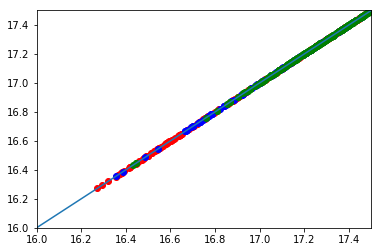

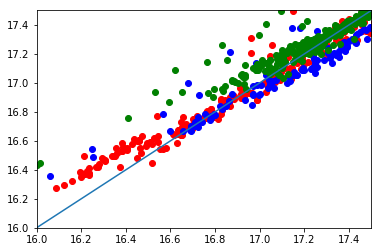

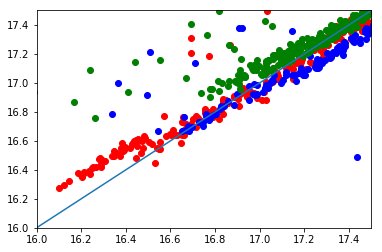

In [300]:
mask_help = help_cat['m_ap_megacam_r']<17.5
mask_chi2 = (master['MAG_APER_r_2']<17.5) & (master['MAG_APER_r_2']>0)
idx1_bright,idx2_bright,sep_bright,_ = search_around_sky(lofar_skycoord[mask_chi2],help_skycoord[mask_help],1*u.arcsec)

help_r_bright = help_cat[mask_help][idx2_bright]
chi2_r_bright = master[mask_chi2][idx1_bright]
ra = chi2_r_bright['ALPHA_J2000']
dec = chi2_r_bright['DELTA_J2000']

mask = (ra>162.9)&(ra<164.5) & (dec>57.3)&(dec<58.1)
x = help_r_bright['m_ap_megacam_r'][mask]
y = help_r_bright['m_ap_megacam_r'][mask]#/(1.6*0.8)
plt.scatter(x,y,color='red',label='region 1')


mask =  (ra>161.2)&(ra<162.6) & (dec>56.6)&(dec<57.3)
x = help_r_bright['m_ap_megacam_r'][mask]
y = help_r_bright['m_ap_megacam_r'][mask]#/(1.6*0.8)
plt.scatter(x,y,color='blue',label='region 2')

mask =  (ra>161.2)&(ra<162.8) & (dec>57.6)&(dec<59.8)
x = help_r_bright['m_ap_megacam_r'][mask]
y = help_r_bright['m_ap_megacam_r'][mask]#/(1.6*0.8)
plt.scatter(x,y,color='green',label='region 3')

plt.plot([16,17.5],[16,17.5])
plt.xlim(16,17.5)
plt.ylim(16,17.5)
plt.show()



mask = (ra>162.9)&(ra<164.5) & (dec>57.3)&(dec<58.1)
x = help_r_bright['m_ap_wfc_r'][mask]
y = help_r_bright['m_ap_megacam_r'][mask]#/(1.6*0.8)
plt.scatter(x,y,color='red',label='region 1')


mask =  (ra>161.2)&(ra<162.6) & (dec>56.6)&(dec<57.3)
x = help_r_bright['m_ap_wfc_r'][mask]
y = help_r_bright['m_ap_megacam_r'][mask]#/(1.6*0.8)
plt.scatter(x,y,color='blue',label='region 2')

mask =  (ra>161.2)&(ra<162.8) & (dec>57.6)&(dec<59.8)
x = help_r_bright['m_ap_wfc_r'][mask]
y = help_r_bright['m_ap_megacam_r'][mask]#/(1.6*0.8)
plt.scatter(x,y,color='green',label='region 3')

plt.plot([16,17.5],[16,17.5])
plt.xlim(16,17.5)
plt.ylim(16,17.5)
plt.show()


mask = (ra>162.9)&(ra<164.5) & (dec>57.3)&(dec<58.1)
x = help_r_bright['m_ap_gpc1_r'][mask]
y = help_r_bright['m_ap_megacam_r'][mask]#/(1.6*0.8)
plt.scatter(x,y,color='red',label='region 1')


mask =  (ra>161.2)&(ra<162.6) & (dec>56.6)&(dec<57.3)
x = help_r_bright['m_ap_gpc1_r'][mask]
y = help_r_bright['m_ap_megacam_r'][mask]#/(1.6*0.8)
plt.scatter(x,y,color='blue',label='region 2')

mask =  (ra>161.2)&(ra<162.8) & (dec>57.6)&(dec<59.8)
x = help_r_bright['m_ap_gpc1_r'][mask]
y = help_r_bright['m_ap_megacam_r'][mask]#/(1.6*0.8)
plt.scatter(x,y,color='green',label='region 3')

plt.plot([16,17.5],[16,17.5])
plt.xlim(16,17.5)
plt.ylim(16,17.5)
plt.show()

In [291]:
help_r_bright.colnames

['help_id',
 'field',
 'ra',
 'dec',
 'hp_idx',
 'f_ap_wfc_u',
 'ferr_ap_wfc_u',
 'm_ap_wfc_u',
 'merr_ap_wfc_u',
 'f_wfc_u',
 'ferr_wfc_u',
 'm_wfc_u',
 'merr_wfc_u',
 'f_ap_wfc_g',
 'ferr_ap_wfc_g',
 'm_ap_wfc_g',
 'merr_ap_wfc_g',
 'f_wfc_g',
 'ferr_wfc_g',
 'm_wfc_g',
 'merr_wfc_g',
 'f_ap_wfc_r',
 'ferr_ap_wfc_r',
 'm_ap_wfc_r',
 'merr_ap_wfc_r',
 'f_wfc_r',
 'ferr_wfc_r',
 'm_wfc_r',
 'merr_wfc_r',
 'f_ap_wfc_i',
 'ferr_ap_wfc_i',
 'm_ap_wfc_i',
 'merr_ap_wfc_i',
 'f_wfc_i',
 'ferr_wfc_i',
 'm_wfc_i',
 'merr_wfc_i',
 'f_ap_wfc_z',
 'ferr_ap_wfc_z',
 'm_ap_wfc_z',
 'merr_ap_wfc_z',
 'f_wfc_z',
 'ferr_wfc_z',
 'm_wfc_z',
 'merr_wfc_z',
 'f_ap_gpc1_g',
 'ferr_ap_gpc1_g',
 'm_ap_gpc1_g',
 'merr_ap_gpc1_g',
 'f_gpc1_g',
 'ferr_gpc1_g',
 'm_gpc1_g',
 'merr_gpc1_g',
 'f_ap_gpc1_r',
 'ferr_ap_gpc1_r',
 'm_ap_gpc1_r',
 'merr_ap_gpc1_r',
 'f_gpc1_r',
 'ferr_gpc1_r',
 'm_gpc1_r',
 'merr_gpc1_r',
 'f_ap_gpc1_i',
 'ferr_ap_gpc1_i',
 'm_ap_gpc1_i',
 'merr_ap_gpc1_i',
 'f_gpc1_i',
 'ferr_gpc1_i

/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


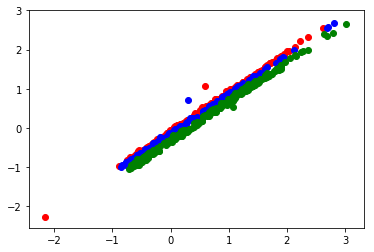

In [257]:
mask_help = help_cat['m_ap_megacam_r']<17.5
mask_chi2 = (master['MAG_APER_r_2']<17.5) & (master['MAG_APER_r_2']>0)
idx1_bright,idx2_bright,sep_bright,_ = search_around_sky(lofar_skycoord[mask_chi2],help_skycoord[mask_help],1*u.arcsec)

help_r_bright = help_cat[mask_help][idx2_bright]
chi2_r_bright = master[mask_chi2][idx1_bright]
ra = chi2_r_bright['ALPHA_J2000']
dec = chi2_r_bright['DELTA_J2000']

mask = (ra>162.9)&(ra<164.5) & (dec>57.3)&(dec<58.1)
x = help_r_bright['m_ap_megacam_r'][mask] - help_r_bright['m_ap_ukidss_k'][mask]
y = chi2_r_bright['MAG_APER_r_2'][mask] - chi2_r_bright['MAG_APER_K_2'][mask]
plt.scatter(x,y,color='red',label='region 1')


mask =  (ra>161.2)&(ra<162.6) & (dec>56.6)&(dec<57.3)
x = help_r_bright['m_ap_megacam_r'][mask] - help_r_bright['m_ap_ukidss_k'][mask]
y = chi2_r_bright['MAG_APER_r_2'][mask] - chi2_r_bright['MAG_APER_K_2'][mask]
plt.scatter(x,y,color='blue',label='region 2')

mask =  (ra>161.2)&(ra<162.8) & (dec>57.6)&(dec<59.8)
x = help_r_bright['m_ap_megacam_r'][mask] - help_r_bright['m_ap_ukidss_k'][mask]
y = chi2_r_bright['MAG_APER_r_2'][mask] - chi2_r_bright['MAG_APER_K_2'][mask]
plt.scatter(x,y,color='green',label='region 3')
plt.show()

In [248]:
len(lofar_skycoord[mask_chi2])

3517

In [253]:
idx2_bright

array([1330, 1350, 1324, ..., 1672, 1673, 1691])

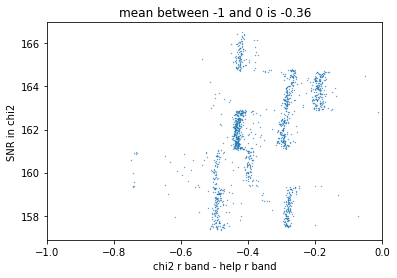

In [137]:
mask = (d2d < 1.0) & (master['MAG_APER_r_2']<17) 
x = master['MAG_APER_r_2'][mask] - help_cat['m_ap_megacam_r'][idx1][mask]
y = master['ALPHA_J2000'][mask]
plt.scatter(x,y,s=0.1)
plt.xlim(-1,0)
#plt.ylim(-1,5)
plt.xlabel('chi2 r band - help r band')
plt.ylabel('SNR in chi2')
plt.title('mean between -1 and 0 is -0.36')
plt.show()

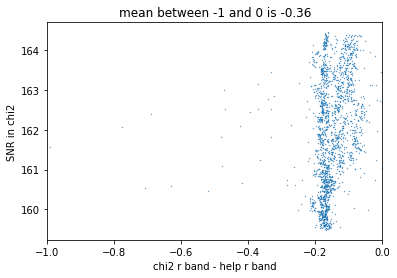

In [140]:
mask = (d2d < 1.0) & (master['MAG_APER_K_2']<15) 
x = master['MAG_APER_K_2'][mask] - help_cat['m_ap_ukidss_k'][idx1][mask]
y = master['ALPHA_J2000'][mask]
plt.scatter(x,y,s=0.1)
plt.xlim(-1,0)
#plt.ylim(-1,5)
plt.xlabel('chi2 K band - help K band')
plt.ylabel('SNR in chi2')
plt.title('mean between -1 and 0 is -0.36')
plt.show()

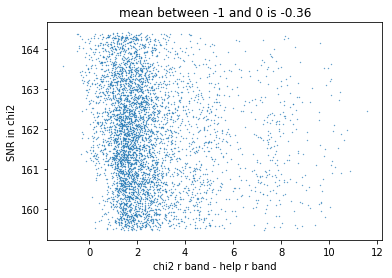

In [147]:
mask = (d2d < 1.0) & (master['MAG_APER_K_2']<17) 
x = help_cat['m_ap_megacam_r'][idx1][mask] - help_cat['m_ap_ukidss_k'][idx1][mask]
y = master['ALPHA_J2000'][mask]
plt.scatter(x,y,s=0.1)
#plt.xlim(-1,0)
#plt.ylim(-1,5)
plt.xlabel('chi2 r band - help r band')
plt.ylabel('SNR in chi2')
plt.title('mean between -1 and 0 is -0.36')
plt.show()

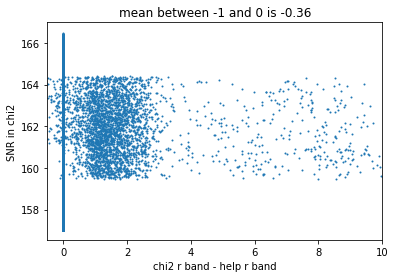

In [150]:
mask = (d2d < 1.0) & (master['MAG_APER_K_2']<17) 
x = master['MAG_APER_r_2'][mask] - master['MAG_APER_K_2'][mask]
y = master['ALPHA_J2000'][mask]
plt.scatter(x,y,s=1)
plt.xlim(-0.5,10)
#plt.ylim(-1,5)
plt.xlabel('chi2 r band - help r band')
plt.ylabel('SNR in chi2')
plt.title('mean between -1 and 0 is -0.36')
plt.show()

In [129]:
mask = (x<0) & (x>-1)
np.mean(x[mask])

-0.36201308707705315

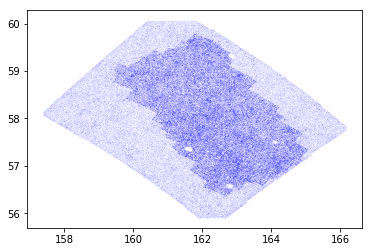

In [13]:
mask = master['FLUX_APER_sw2_3']/master['FLUXERR_APER_sw2_3']>3
x = master['ALPHA_J2000'][mask]
y = master['DELTA_J2000'][mask]
plt.scatter(x,y,s=0.00001,c='blue')

mask = master['FLUX_APER_se2_3']/master['FLUXERR_APER_se2_3']>3
x = master['ALPHA_J2000'][mask]
y = master['DELTA_J2000'][mask]
plt.scatter(x,y,s=0.00001,c='blue')


plt.show()

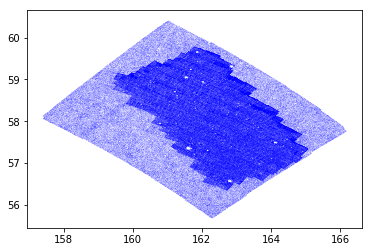

In [23]:
mask = ~np.isnan(help_cat['f_ap_irac_i2'])
x = help_cat['ra'][mask]
y = help_cat['dec'][mask]
plt.scatter(x,y,s=0.0001,c='blue')


plt.show()


In [24]:
mask = inMoc(help_cat['ra'],help_cat['dec'],moc_se2)
mask = mask & (~(np.isnan(help_cat['f_ap_irac_i2']))) & (help_cat['f_ap_irac_i2']/help_cat['ferr_ap_irac_i2']>3)
print('number of help irac sources in the servs region is: {}'.format(np.sum(mask)))

mask = inMoc(master['ALPHA_J2000'],master['DELTA_J2000'],moc_se2)
mask = mask & (master['FLUX_APER_se2_3']/master['FLUXERR_APER_se2_3']>3)
print('number of lofar servs sources in the servs region is: {}'.format(np.sum(mask)))

/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


number of help irac sources in the servs region is: 527022
number of lofar servs sources in the servs region is: 432246


In [ ]:
moc_sw_only = moc_sw2 - moc_se2
print(moc_sw_only.area_sq_deg)

In [26]:
mask = inMoc(help_cat['ra'],help_cat['dec'],moc_sw_only)
mask = mask & (~(np.isnan(help_cat['f_ap_irac_i2']))) & (help_cat['f_ap_irac_i2']/help_cat['ferr_ap_irac_i2']>3)
print('number of help irac sources in the servs region is: {}'.format(np.sum(mask)))

mask = inMoc(master['ALPHA_J2000'],master['DELTA_J2000'],moc_sw_only)
mask = mask & (master['FLUX_APER_sw2_3']/master['FLUXERR_APER_sw2_3']>3)
print('number of lofar servs sources in the servs region is: {}'.format(np.sum(mask)))

number of help irac sources in the servs region is: 207111
number of lofar servs sources in the servs region is: 286212


In [29]:
mask = inMoc(help_cat['ra'],help_cat['dec'],moc_se2)
mask = mask & (~(np.isnan(help_cat['f_ap_megacam_r']))) & (help_cat['f_ap_megacam_r']/help_cat['ferr_ap_megacam_r']>3)
print('number of help irac sources in the servs region is: {}'.format(np.sum(mask)))

mask = inMoc(master['ALPHA_J2000'],master['DELTA_J2000'],moc_se2)
mask = mask & (master['FLUX_APER_r_3']/master['FLUXERR_APER_r_3']>3)
print('number of lofar servs sources in the servs region is: {}'.format(np.sum(mask)))

number of help irac sources in the servs region is: 980436
number of lofar servs sources in the servs region is: 752977


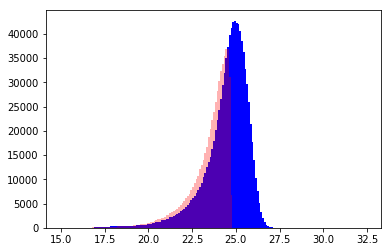

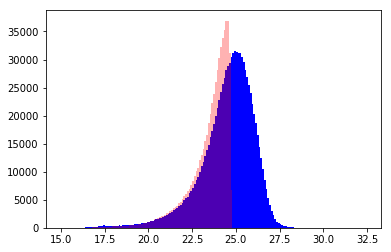

In [97]:
bins = np.arange(15,32.5,0.1)
maskmoc = inMoc(help_cat['ra'],help_cat['dec'],moc_se2)
mask = maskmoc & (~(np.isnan(help_cat['f_ap_megacam_r']))) & (help_cat['f_ap_megacam_r']/help_cat['ferr_ap_megacam_r']>0)
y = help_cat['m_ap_megacam_r'][mask]
plt.hist(y,bins=bins,color='blue')

maskmoc = inMoc(master['ALPHA_J2000'],master['DELTA_J2000'],moc_se2)
mask = maskmoc & (master['FLUX_APER_r_3']/master['FLUXERR_APER_r_3']>3)
y = master['MAG_APER_r_3'][mask]
plt.hist(y,bins=bins,color='red',alpha=0.3)
plt.show()

maskmoc = inMoc(help_cat['ra'],help_cat['dec'],moc_se2)
mask = maskmoc & (~(np.isnan(help_cat['f_ap_megacam_r']))) & (help_cat['f_megacam_r']/help_cat['ferr_megacam_r']>0)
y = help_cat['m_megacam_r'][mask]
plt.hist(y,bins=bins,color='blue')

maskmoc = inMoc(master['ALPHA_J2000'],master['DELTA_J2000'],moc_se2)
mask = maskmoc & (master['FLUX_APER_r_3']/master['FLUXERR_APER_r_3']>3)
y = master['MAG_APER_r_3'][mask]
plt.hist(y,bins=bins,color='red',alpha=0.3)
plt.show()

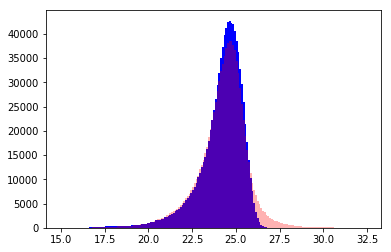

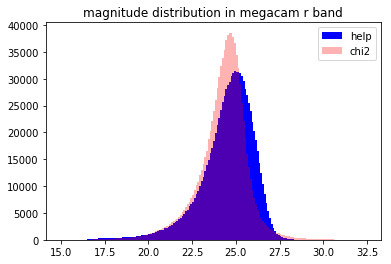

In [106]:
bins = np.arange(15,32.5,0.1)
maskmoc = inMoc(help_cat['ra'],help_cat['dec'],moc_se2)
mask = maskmoc & (~(np.isnan(help_cat['f_ap_megacam_r']))) & (help_cat['f_ap_megacam_r']/help_cat['ferr_ap_megacam_r']>0)
y = help_cat['m_ap_megacam_r'][mask] - 0.3
plt.hist(y,bins=bins,color='blue')

maskmoc = inMoc(master['ALPHA_J2000'],master['DELTA_J2000'],moc_se2)
mask = maskmoc & (master['FLUX_APER_r_3'] != -99)
y = master['MAG_APER_r_3'][mask]
plt.hist(y,bins=bins,color='red',alpha=0.3)
plt.show()

maskmoc = inMoc(help_cat['ra'],help_cat['dec'],moc_se2)
mask = maskmoc & (~(np.isnan(help_cat['f_ap_megacam_r']))) & (help_cat['f_megacam_r']/help_cat['ferr_megacam_r']>0)
y = help_cat['m_megacam_r'][mask]
plt.hist(y,bins=bins,color='blue',label='help')

maskmoc = inMoc(master['ALPHA_J2000'],master['DELTA_J2000'],moc_se2)
mask = maskmoc & (master['FLUX_APER_r_3'] != -99)
y = master['MAG_APER_r_3'][mask]
plt.hist(y,bins=bins,color='red',alpha=0.3,label='chi2')

plt.title('magnitude distribution in megacam r band')
plt.legend()
plt.show()

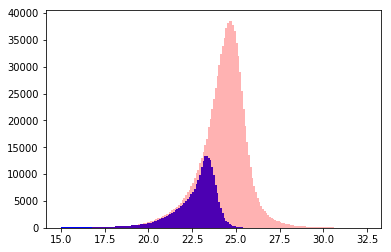

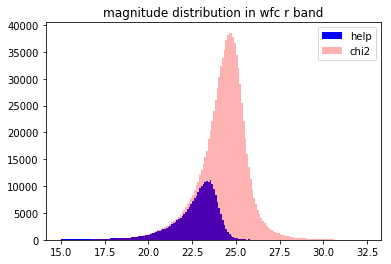

In [104]:
bins = np.arange(15,32.5,0.1)
maskmoc = inMoc(help_cat['ra'],help_cat['dec'],moc_se2)
mask = maskmoc & (~(np.isnan(help_cat['f_ap_wfc_r']))) & (help_cat['f_ap_wfc_r']/help_cat['ferr_ap_wfc_r']>0)
y = help_cat['m_ap_wfc_r'][mask]
plt.hist(y,bins=bins,color='blue')

maskmoc = inMoc(master['ALPHA_J2000'],master['DELTA_J2000'],moc_se2)
mask = maskmoc & (master['FLUX_APER_r_3'] != -99)
y = master['MAG_APER_r_3'][mask]
plt.hist(y,bins=bins,color='red',alpha=0.3)
plt.show()

maskmoc = inMoc(help_cat['ra'],help_cat['dec'],moc_se2)
mask = maskmoc & (~(np.isnan(help_cat['f_ap_wfc_r']))) & (help_cat['f_wfc_r']/help_cat['ferr_wfc_r']>0)
y = help_cat['m_wfc_r'][mask]
plt.hist(y,bins=bins,color='blue',label='help')

maskmoc = inMoc(master['ALPHA_J2000'],master['DELTA_J2000'],moc_se2)
mask = maskmoc & (master['FLUX_APER_r_3'] != -99)
y = master['MAG_APER_r_3'][mask]
plt.hist(y,bins=bins,color='red',alpha=0.3,label='chi2')

plt.title('magnitude distribution in wfc r band')
plt.legend()
plt.show()

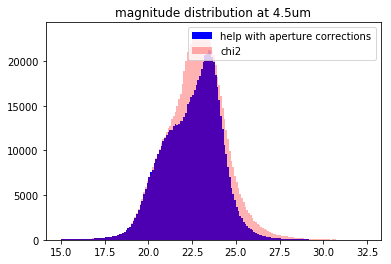

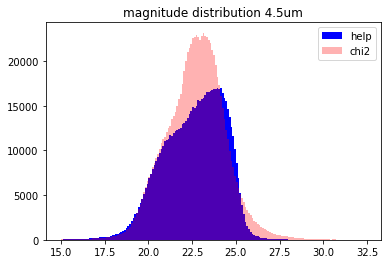

In [103]:
bins = np.arange(15,32.5,0.1)
maskmoc = inMoc(help_cat['ra'],help_cat['dec'],moc_se2)
mask = maskmoc & (~(np.isnan(help_cat['f_ap_irac_i2']))) & (help_cat['f_ap_irac_i2']/help_cat['ferr_ap_irac_i2']>0)
y = help_cat['m_ap_irac_i2'][mask]
plt.hist(y,bins=bins,color='blue',label='help with aperture corrections')

maskmoc = inMoc(master['ALPHA_J2000'],master['DELTA_J2000'],moc_se2)
mask = maskmoc & (master['FLUX_APER_se2_3'] != -99)
y = master['MAG_APER_se2_3'][mask]
plt.hist(y,bins=bins,color='red',alpha=0.3,label='chi2')
plt.title('magnitude distribution at 4.5um')
plt.legend()
plt.show()

maskmoc = inMoc(help_cat['ra'],help_cat['dec'],moc_se2)
mask = maskmoc & (~(np.isnan(help_cat['f_ap_irac_i2']))) & (help_cat['f_irac_i2']/help_cat['ferr_irac_i2']>0)
y = help_cat['m_irac_i2'][mask]
plt.hist(y,bins=bins,color='blue',label='help')

maskmoc = inMoc(master['ALPHA_J2000'],master['DELTA_J2000'],moc_se2)
mask = maskmoc & (master['FLUX_APER_se2_3'] != -99)
y = master['MAG_APER_se2_3'][mask]
plt.hist(y,bins=bins,color='red',alpha=0.3,label='chi2')

plt.title('magnitude distribution 4.5um')
plt.legend()
plt.show()

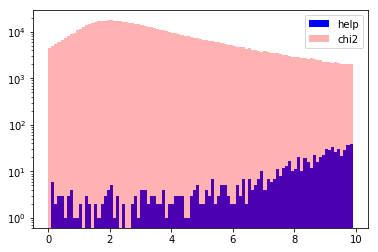

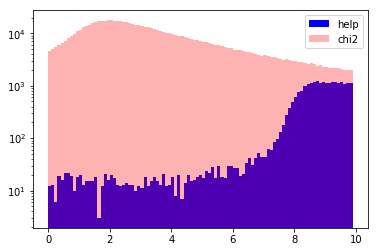

In [93]:
bins = np.arange(0,10,0.1)
maskmoc = inMoc(help_cat['ra'],help_cat['dec'],moc_se2)
mask = maskmoc & (~(np.isnan(help_cat['f_ap_megacam_r'])))
y = help_cat['f_ap_megacam_r'][mask]/help_cat['ferr_ap_megacam_r'][mask]
plt.hist(y,bins=bins,log=True,color='blue',label='help')

maskmoc = inMoc(master['ALPHA_J2000'],master['DELTA_J2000'],moc_se2)
mask = maskmoc & (master['FLUX_APER_r_3']/master['FLUXERR_APER_r_3']>0)
y = master['FLUX_APER_r_3'][mask]/master['FLUXERR_APER_r_3'][mask]
plt.hist(y,bins=bins,log=True,color='red',alpha=0.3,label='chi2')

plt.legend()
plt.show()

bins = np.arange(0,10,0.1)
maskmoc = inMoc(help_cat['ra'],help_cat['dec'],moc_se2)
mask = maskmoc & (~(np.isnan(help_cat['f_megacam_r'])))
y = help_cat['f_megacam_r'][mask]/help_cat['ferr_megacam_r'][mask]
plt.hist(y,bins=bins,log=True,color='blue',label='help')

maskmoc = inMoc(master['ALPHA_J2000'],master['DELTA_J2000'],moc_se2)
mask = maskmoc & (master['FLUX_APER_r_3']/master['FLUXERR_APER_r_3']>0)
y = master['FLUX_APER_r_3'][mask]/master['FLUXERR_APER_r_3'][mask]
plt.hist(y,bins=bins,log=True,color='red',alpha=0.3,label='chi2')

plt.legend()
plt.show()

In [84]:
bins = np.arange(0,10,0.1)
maskmoc = inMoc(help_cat['ra'],help_cat['dec'],moc_se2)
mask = maskmoc & (~(np.isnan(help_cat['f_ap_megacam_r']))) & (help_cat['f_ap_megacam_r']/help_cat['ferr_ap_megacam_r']<3)
y = help_cat['f_ap_megacam_r'][mask]/help_cat['ferr_ap_megacam_r'][mask]

/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


In [87]:
help_cat[mask]

help_id,field,ra,dec,hp_idx,f_ap_wfc_u,ferr_ap_wfc_u,m_ap_wfc_u,merr_ap_wfc_u,f_wfc_u,ferr_wfc_u,m_wfc_u,merr_wfc_u,f_ap_wfc_g,ferr_ap_wfc_g,m_ap_wfc_g,merr_ap_wfc_g,f_wfc_g,ferr_wfc_g,m_wfc_g,merr_wfc_g,f_ap_wfc_r,ferr_ap_wfc_r,m_ap_wfc_r,merr_ap_wfc_r,f_wfc_r,ferr_wfc_r,m_wfc_r,merr_wfc_r,f_ap_wfc_i,ferr_ap_wfc_i,m_ap_wfc_i,merr_ap_wfc_i,f_wfc_i,ferr_wfc_i,m_wfc_i,merr_wfc_i,f_ap_wfc_z,ferr_ap_wfc_z,m_ap_wfc_z,merr_ap_wfc_z,f_wfc_z,ferr_wfc_z,m_wfc_z,merr_wfc_z,f_ap_gpc1_g,ferr_ap_gpc1_g,m_ap_gpc1_g,merr_ap_gpc1_g,f_gpc1_g,ferr_gpc1_g,m_gpc1_g,merr_gpc1_g,f_ap_gpc1_r,ferr_ap_gpc1_r,m_ap_gpc1_r,merr_ap_gpc1_r,f_gpc1_r,ferr_gpc1_r,m_gpc1_r,merr_gpc1_r,f_ap_gpc1_i,ferr_ap_gpc1_i,m_ap_gpc1_i,merr_ap_gpc1_i,f_gpc1_i,ferr_gpc1_i,m_gpc1_i,merr_gpc1_i,f_ap_gpc1_z,ferr_ap_gpc1_z,m_ap_gpc1_z,merr_ap_gpc1_z,f_gpc1_z,ferr_gpc1_z,m_gpc1_z,merr_gpc1_z,f_ap_gpc1_y,ferr_ap_gpc1_y,m_ap_gpc1_y,merr_ap_gpc1_y,f_gpc1_y,ferr_gpc1_y,m_gpc1_y,merr_gpc1_y,f_ap_megacam_u,ferr_ap_megacam_u,m_ap_megacam_u,merr_ap_megacam_u,f_megacam_u,ferr_megacam_u,m_megacam_u,merr_megacam_u,f_ap_megacam_g,ferr_ap_megacam_g,m_ap_megacam_g,merr_ap_megacam_g,f_megacam_g,ferr_megacam_g,m_megacam_g,merr_megacam_g,f_ap_megacam_r,ferr_ap_megacam_r,m_ap_megacam_r,merr_ap_megacam_r,f_megacam_r,ferr_megacam_r,m_megacam_r,merr_megacam_r,f_ap_megacam_z,ferr_ap_megacam_z,m_ap_megacam_z,merr_ap_megacam_z,f_megacam_z,ferr_megacam_z,m_megacam_z,merr_megacam_z,f_ap_ukidss_k,ferr_ap_ukidss_k,m_ap_ukidss_k,merr_ap_ukidss_k,f_ukidss_k,ferr_ukidss_k,m_ukidss_k,merr_ukidss_k,f_ap_irac_i3,ferr_ap_irac_i3,m_ap_irac_i3,merr_ap_irac_i3,f_irac_i3,ferr_irac_i3,m_irac_i3,merr_irac_i3,f_ap_irac_i4,ferr_ap_irac_i4,m_ap_irac_i4,merr_ap_irac_i4,f_irac_i4,ferr_irac_i4,m_irac_i4,merr_irac_i4,f_ap_irac_i1,ferr_ap_irac_i1,m_ap_irac_i1,merr_ap_irac_i1,f_irac_i1,ferr_irac_i1,m_irac_i1,merr_irac_i1,f_ap_irac_i2,ferr_ap_irac_i2,m_ap_irac_i2,merr_ap_irac_i2,f_irac_i2,ferr_irac_i2,m_irac_i2,merr_irac_i2,f_ap_ukidss_j,ferr_ap_ukidss_j,m_ap_ukidss_j,merr_ap_ukidss_j,f_ukidss_j,ferr_ukidss_j,m_ukidss_j,merr_ukidss_j,m_megacam_i,ferr_megacam_i,merr_megacam_i,f_megacam_i,m_megacam_y,ferr_megacam_y,merr_megacam_y,f_megacam_y,stellarity,stellarity_origin,zspec,zspec_qual,zspec_association_flag,ebv,f_mips_24,ferr_mips_24,flag_mips_24,f_pacs_green,ferr_pacs_green,flag_pacs_green,f_pacs_red,ferr_pacs_red,flag_pacs_red,f_spire_250,ferr_spire_250,flag_spire_250,f_spire_350,ferr_spire_350,flag_spire_350,f_spire_500,ferr_spire_500,flag_spire_500,redshift,flag_megacam_i,flag_megacam_y,flag_cleaned,flag_merged,flag_gaia,flag_optnir_obs,flag_optnir_det,flag_gpc1_g,flag_gpc1_r,flag_gpc1_i,flag_gpc1_z,flag_gpc1_y,flag_irac_i1,flag_irac_i2,flag_irac_i3,flag_irac_i4,flag_wfc_u,flag_megacam_u,flag_wfc_g,flag_megacam_g,flag_wfc_r,flag_megacam_r,flag_wfc_i,flag_wfc_z,flag_megacam_z,cigale_mstar,cigale_mstar_err,cigale_sfr,cigale_sfr_err,cigale_dustlumin,cigale_dustlumin_err,cigale_dustlumin_ironly,cigale_dustlumin_ironly_err,flag_cigale,flag_cigale_opt,flag_cigale_ir,flag_cigale_ironly
,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,mag,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,uJy,uJy,,,uJy,uJy,,,uJy,uJy,,,uJy,uJy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,uJy,,,mJy,,,mJy,,,mJy,,,mJy,,,mJy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
bytes33,bytes18,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float

In [90]:
mask = maskmoc & (~(np.isnan(help_cat['f_ap_megacam_r']))) & (help_cat['m_ap_megacam_r']>30)
help_cat[mask]

/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


help_id,field,ra,dec,hp_idx,f_ap_wfc_u,ferr_ap_wfc_u,m_ap_wfc_u,merr_ap_wfc_u,f_wfc_u,ferr_wfc_u,m_wfc_u,merr_wfc_u,f_ap_wfc_g,ferr_ap_wfc_g,m_ap_wfc_g,merr_ap_wfc_g,f_wfc_g,ferr_wfc_g,m_wfc_g,merr_wfc_g,f_ap_wfc_r,ferr_ap_wfc_r,m_ap_wfc_r,merr_ap_wfc_r,f_wfc_r,ferr_wfc_r,m_wfc_r,merr_wfc_r,f_ap_wfc_i,ferr_ap_wfc_i,m_ap_wfc_i,merr_ap_wfc_i,f_wfc_i,ferr_wfc_i,m_wfc_i,merr_wfc_i,f_ap_wfc_z,ferr_ap_wfc_z,m_ap_wfc_z,merr_ap_wfc_z,f_wfc_z,ferr_wfc_z,m_wfc_z,merr_wfc_z,f_ap_gpc1_g,ferr_ap_gpc1_g,m_ap_gpc1_g,merr_ap_gpc1_g,f_gpc1_g,ferr_gpc1_g,m_gpc1_g,merr_gpc1_g,f_ap_gpc1_r,ferr_ap_gpc1_r,m_ap_gpc1_r,merr_ap_gpc1_r,f_gpc1_r,ferr_gpc1_r,m_gpc1_r,merr_gpc1_r,f_ap_gpc1_i,ferr_ap_gpc1_i,m_ap_gpc1_i,merr_ap_gpc1_i,f_gpc1_i,ferr_gpc1_i,m_gpc1_i,merr_gpc1_i,f_ap_gpc1_z,ferr_ap_gpc1_z,m_ap_gpc1_z,merr_ap_gpc1_z,f_gpc1_z,ferr_gpc1_z,m_gpc1_z,merr_gpc1_z,f_ap_gpc1_y,ferr_ap_gpc1_y,m_ap_gpc1_y,merr_ap_gpc1_y,f_gpc1_y,ferr_gpc1_y,m_gpc1_y,merr_gpc1_y,f_ap_megacam_u,ferr_ap_megacam_u,m_ap_megacam_u,merr_ap_megacam_u,f_megacam_u,ferr_megacam_u,m_megacam_u,merr_megacam_u,f_ap_megacam_g,ferr_ap_megacam_g,m_ap_megacam_g,merr_ap_megacam_g,f_megacam_g,ferr_megacam_g,m_megacam_g,merr_megacam_g,f_ap_megacam_r,ferr_ap_megacam_r,m_ap_megacam_r,merr_ap_megacam_r,f_megacam_r,ferr_megacam_r,m_megacam_r,merr_megacam_r,f_ap_megacam_z,ferr_ap_megacam_z,m_ap_megacam_z,merr_ap_megacam_z,f_megacam_z,ferr_megacam_z,m_megacam_z,merr_megacam_z,f_ap_ukidss_k,ferr_ap_ukidss_k,m_ap_ukidss_k,merr_ap_ukidss_k,f_ukidss_k,ferr_ukidss_k,m_ukidss_k,merr_ukidss_k,f_ap_irac_i3,ferr_ap_irac_i3,m_ap_irac_i3,merr_ap_irac_i3,f_irac_i3,ferr_irac_i3,m_irac_i3,merr_irac_i3,f_ap_irac_i4,ferr_ap_irac_i4,m_ap_irac_i4,merr_ap_irac_i4,f_irac_i4,ferr_irac_i4,m_irac_i4,merr_irac_i4,f_ap_irac_i1,ferr_ap_irac_i1,m_ap_irac_i1,merr_ap_irac_i1,f_irac_i1,ferr_irac_i1,m_irac_i1,merr_irac_i1,f_ap_irac_i2,ferr_ap_irac_i2,m_ap_irac_i2,merr_ap_irac_i2,f_irac_i2,ferr_irac_i2,m_irac_i2,merr_irac_i2,f_ap_ukidss_j,ferr_ap_ukidss_j,m_ap_ukidss_j,merr_ap_ukidss_j,f_ukidss_j,ferr_ukidss_j,m_ukidss_j,merr_ukidss_j,m_megacam_i,ferr_megacam_i,merr_megacam_i,f_megacam_i,m_megacam_y,ferr_megacam_y,merr_megacam_y,f_megacam_y,stellarity,stellarity_origin,zspec,zspec_qual,zspec_association_flag,ebv,f_mips_24,ferr_mips_24,flag_mips_24,f_pacs_green,ferr_pacs_green,flag_pacs_green,f_pacs_red,ferr_pacs_red,flag_pacs_red,f_spire_250,ferr_spire_250,flag_spire_250,f_spire_350,ferr_spire_350,flag_spire_350,f_spire_500,ferr_spire_500,flag_spire_500,redshift,flag_megacam_i,flag_megacam_y,flag_cleaned,flag_merged,flag_gaia,flag_optnir_obs,flag_optnir_det,flag_gpc1_g,flag_gpc1_r,flag_gpc1_i,flag_gpc1_z,flag_gpc1_y,flag_irac_i1,flag_irac_i2,flag_irac_i3,flag_irac_i4,flag_wfc_u,flag_megacam_u,flag_wfc_g,flag_megacam_g,flag_wfc_r,flag_megacam_r,flag_wfc_i,flag_wfc_z,flag_megacam_z,cigale_mstar,cigale_mstar_err,cigale_sfr,cigale_sfr_err,cigale_dustlumin,cigale_dustlumin_err,cigale_dustlumin_ironly,cigale_dustlumin_ironly_err,flag_cigale,flag_cigale_opt,flag_cigale_ir,flag_cigale_ironly
,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,mag,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,uJy,uJy,,,uJy,uJy,,,uJy,uJy,,,uJy,uJy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,uJy,,,mJy,,,mJy,,,mJy,,,mJy,,,mJy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
bytes33,bytes18,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float